# Stacks how do they work
## Participants: poqit

Stacking continues to gain acceptance but there is less consensus on why exactly stacks are valuable in BBM.

This analysis seeks to definitively prove one major source of value for stacking - namely, that stacked rosters have a higher likelihood of containing multiple of the highest-scoring players in a given week. 

To prove this point, I first recreate Michael Leone's analysis of the relationship between stack sizes and probability of winning a BBM-sized final round. I expand on Leone's work by first defining a group of the highest-scoring players in each week and demonstrating that (1) entries likely need multiple of these players to win a BBM-style final round, and (2) larger stacks tend to have more of these players, which accounts for the higher likelihood of winning identified by Leone.

I then explain why stacks allow rosters to access more high-scoring players by calculating the number of feasible combinations of N top-scorers in each week and determining how many combinations involve stacked players. I find that the percentage of feasible combinations involving stacks grows with N.  Thus, stacks provide access to more possible combinations of top scorers, which leads to higher win rates.

## Data preparation

Execute the first two blocks below, then choose between the 3rd and 4th blocks. 3rd is preferred for time-saving purposes. More context included in blocks below.

In [5]:
# Imports
import pandas as pd
import numpy as np
from operator import itemgetter
import nfl_data_py as nfl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [15]:
# Load data on weekly fantasy production; this data is publicly available on fantasydata.com
url_pts = 'https://storage.googleapis.com/bb_data_bowl/fantasy_score_data.csv'
df_fpts = pd.read_csv(url_pts)

# Load file that maps underdog player names to fantasy production data player names
url_names = 'https://storage.googleapis.com/bb_data_bowl/UD_Fantasy_Score_Name_Mapping%20-%20OUTPUT.csv'
df_names = pd.read_csv(url_names)
df_names['ud_name_pos'] = df_names['ud_name'] + "_" + df_names['ud_pos']
df_names['score_name_pos'] = df_names['score_name'] + "_" + df_names['score_pos']
dict_names = dict(zip(df_names['ud_name_pos'], df_names['score_name_pos']))

# Load file that maps team abbreviations from Underdog format to fantasydata.com format
url_teams = 'https://storage.googleapis.com/bb_data_bowl/team_name_mapping.csv'
team_mapping = pd.read_csv(url_teams)
dict_team = dict(zip(team_mapping['fantasy_data'], team_mapping['underdog']))
del team_mapping

# Create dictionary matching players to their teams in each week (allows us to deal with mid-season team switchers)
df_fpts['Team'] = df_fpts['Team'].map(dict_team)
df_fpts['Opponent'] = df_fpts['Opponent'].map(dict_team)
df_fpts['Position'] = np.where(df_fpts['Position']=='FB', 'RB', df_fpts['Position'])
df_fpts['score_name_pos_week'] = df_fpts['Name'] +"_"+ df_fpts['Position']+"_"+df_fpts['Week'].astype(str)
dict_name_week = dict(zip(df_fpts['score_name_pos_week'], df_fpts['Team']))

In [12]:
# Preferred method of data prep - choose either this or block below
# This is preferred because block below will take ~1 hour
# Downside is it doesn't reference the raw data
# However, this csv was produced by the same code below, which does reference the raw data

df = pd.DataFrame()
for i in range(10):
    url = f'https://storage.googleapis.com/bb_data_bowl/df_data_prep_{i}.csv'
    tmp = pd.read_csv(url)
    df = pd.concat([df, tmp])
    del tmp



Index(['Unnamed: 0', 'draft_id', 'draft_time', 'clock', 'draft_entry_id',
       'tournament_entry_id', 'tournament_round_draft_entry_id',
       'tournament_round_number', 'player_name', 'position_name', 'bye_week',
       'projection_adp', 'pick_order', 'overall_pick_number',
       'team_pick_number', 'pick_points', 'roster_points', 'playoff_team',
       'latest_rd', 'identifier', 'team', 'score_0', 'optimal_0', 'role_0',
       'score_1', 'optimal_1', 'role_1', 'score_2', 'optimal_2', 'role_2',
       'score_3', 'optimal_3', 'role_3', 'score_4', 'optimal_4', 'role_4',
       'score_5', 'optimal_5', 'role_5', 'score_6', 'optimal_6', 'role_6',
       'score_7', 'optimal_7', 'role_7', 'score_8', 'optimal_8', 'role_8',
       'score_9', 'optimal_9', 'role_9', 'score_10', 'optimal_10', 'role_10',
       'score_11', 'optimal_11', 'role_11', 'score_12', 'optimal_12',
       'role_12', 'score_13', 'optimal_13', 'role_13', 'score_14',
       'optimal_14', 'role_14', 'score_15', 'optimal_15

In [2]:

# Alternative data prep method to the above
# This utilizes the raw data but takes ~1 hour
# The result of this block is a dataframe identical to the dataframe loaded above
# It essentially shows how to get from raw data to the csv linked above

# Combine individual regular season csvs into one dataframe
df = pd.DataFrame()
for f in range(27): # Files with fast drafts only
    if f < 10:
        num_str = '0' + str(f)
    else:
        num_str = str(f)
    tmp = pd.read_csv(f'../data/2022/regular_season/fast/part_{num_str}.csv')
    df = pd.concat([df,tmp], ignore_index=True)

for m in range(9): # Files with mixed drafts
    num_str = '0' + str(m)
    tmp = pd.read_csv(f'../data/2022/regular_season/mixed/part_{num_str}.csv')
    df = pd.concat([df,tmp], ignore_index=True)

# Add column indicating how far each entry got in tournament 
# 1 = regular season, 2 = quarterfinals, 3 = semifinals, 4 = finals
df['latest_rd'] = 1
for q in range(10): # Files for quarterfinals
    num_str = '0' + str(q)
    tmp = pd.read_csv(f'../data/2022/post_season/quarterfinals/part_{num_str}.csv')
    df['latest_rd'] = np.where(df['tournament_entry_id'].isin(tmp['tournament_entry_id']), 2, df['latest_rd'])
    del tmp

tmp = pd.read_csv(f'../data/2022/post_season/semifinals/part_00.csv') # File for semifinals
df['latest_rd'] = np.where(df['tournament_entry_id'].isin(tmp['tournament_entry_id']), 3, df['latest_rd'])

tmp = pd.read_csv(f'../data/2022/post_season/finals/part_00.csv') # File for finals
df['latest_rd'] = np.where(df['tournament_entry_id'].isin(tmp['tournament_entry_id']), 4, df['latest_rd'])
del tmp

# Get rid of any mentions of FB in position column
df['position_name'] = np.where(df['position_name']=='FB', 'RB', df['position_name'])

# Loop through each week, determine optimal lineup for each entry, and add columns to df
# indicating whether player was in entry's optimal and how many points they contributed
# Global variables with lineup quota by roster slot and positions eligible for flex
LINEUP_POS = {'QB':1, 'RB':2, 'WR':3, 'TE':1, 'FLEX':1}
FLEX_POS = ['RB', 'WR', 'TE']

# Get team names and create dictionary
rosters = nfl.import_rosters([2022])
rosters['position'] = np.where(rosters['position']=='FB', 'RB', rosters['position'])
rosters = rosters[rosters['position'].isin(['QB', 'RB', 'WR', 'TE'])].reset_index(drop=True)
rosters['identifier'] = rosters.player_name.map(lambda x: x.replace('.',''))
rosters['identifier'] = rosters.identifier.map(lambda e: e.replace(' ','_'))
rosters['identifier'] = rosters["position"] + "_" + rosters['identifier']
team_dict = dict(zip(rosters.identifier, rosters.team))

# Create player identifier column
df['identifier'] = df.player_name.map(lambda y: y.replace('.',''))
df['identifier'] = df.identifier.map(lambda z: z.replace(' ', '_'))
df['identifier'] = df['position_name'] + "_" + df['identifier']
df['team'] = df['identifier'].map(team_dict)
df['identifier'] = df['identifier'] + '_' + df['team']
df['identifier'] = np.where(df['player_name']=='Joshua Palmer','WR_Joshua_Palmer_LAC', df['identifier']) # Manually set for Palmer because his was getting screwed up for some reason


rosters_leftover = rosters[~rosters.identifier.isin(df.identifier)].reset_index(drop=True)
rosters_leftover['abbrev_identifier'] = rosters_leftover['position'] + "_" + rosters_leftover['player_name'].astype(str).str[0] + "_" + rosters_leftover['last_name']
team_dict_leftover = dict(zip(rosters_leftover.abbrev_identifier, rosters_leftover.team))

for index, row in df.iterrows():
    if pd.isnull(row['team']):
        name_split = row['player_name'].split(' ')
        abbrev_identifier = row['position_name'] + "_" + name_split[0][0] + '_' + name_split[1]
        if abbrev_identifier not in team_dict_leftover:
            df.at[index,'team'] = 'NA'
        else:
            df.at[index,'team'] = team_dict_leftover[abbrev_identifier]



## Get list of unique entry ids
entries = list(df['draft_entry_id'].unique())

# Loop through each week, identify players in optimal lineup, and update main df
for week in range(1,18):
    print(f'Starting week {week}')
    df_fpts_week = df_fpts[df_fpts['Week']==week].reset_index(drop=True)

    # Create dictionary where keys are player_name-position_name from underdog and values are relevant scores
    score_dict = {}
    for row in range(len(df_fpts_week)):
        name = df_fpts_week.at[row, 'Name']
        pos = df_fpts_week.at[row, 'Position']
        mapped_name = df_names[(df_names['score_name']==name) & (df_names['score_pos']==pos)][['ud_name', 'ud_pos']].reset_index(drop=True)
        if len(mapped_name) > 0:
            score_dict[f'{mapped_name.at[0,"ud_name"]}-{mapped_name.at[0,"ud_pos"]}'] = df_fpts_week.at[row, 'FantasyPointsFanDuel']
    
    # Create dictionary of players selected in each BBM entry
    df.sort_values(by=['draft_entry_id'], inplace=True)
    df.reset_index(drop=True)
    ud_dict = {}
    for y in entries:
        ud_dict[y] = {'QB': [], 'RB': [], 'WR': [], 'TE': []}

    for e in range(len(df)):
        pos = df.at[e, 'position_name']
        if pos == 'FB':
            pos = 'RB'
        player_name = df.at[e, 'player_name']
        pts = score_dict.get(f"{player_name}-{pos}", 0)
        dict_entry = {"name": player_name, "pts": pts, "df_ud_index":e}
        ud_dict[df.at[e, 'draft_entry_id']][pos].append(dict_entry)
    
    # Determine optimal weekly lineups for each entry and add scores to main dataframe
    # First, add score column to main dataframe with all values initially set to zero (scores will 
    # be updated if player is in optimal lineup)
    ud_col_name = f'score_{week}'
    df[ud_col_name] = 0 
    # Second, add binary column to main dataframe that will eventually indicate whether player 
    # was in entry's optimal lineup, but initially set to zero
    ud_binary_col_name = f'optimal_{week}'
    df[ud_binary_col_name] = 0
    # Third, add column to hold player's role in optimal lineup (e.g., RB1, RB2, WR1, WR2, FLEX)
    ud_role = f'role_{week}'
    df[ud_role] = 'NA'

    # Loop through each entry, determine optimal lineup, and update score and binary columns in main df
    for entry in entries:
        # Create list to hold optimal lineup
        optimal_lineup = []
        
        # Get list of players on roster
        players = ud_dict[entry]

        # Loop through lineup positions
        for pos in LINEUP_POS:
            # Get available players and sort by points
            if pos != 'FLEX':
                pos_players = sorted(players[pos], key=itemgetter('pts'), reverse=True)
            else:
                pos_players = []
                for f_pos in FLEX_POS:
                    for f_pos_player in players[f_pos]:
                        if f"{f_pos_player['name']}-{f_pos}" not in optimal_lineup:
                            pos_players.append(f_pos_player)
                pos_players = sorted(pos_players, key=itemgetter('pts'), reverse=True)

            # Loop through roster enough times to meet lineup quota for position
            for i in range(LINEUP_POS[pos]):
                # Get player name and index in main df
                name_to_add = pos_players[i]['name']
                index = pos_players[i]['df_ud_index']
                # Update main df
                df.at[index, ud_col_name] = pos_players[i]['pts']
                df.at[index, ud_binary_col_name] = 1
                df.at[index, ud_role] = f'{pos}{i+1}'
                # Add player to list holding optimal lineup
                if pos != 'FLEX':
                    optimal_lineup.append(f"{name_to_add}-{pos}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


# Context

Stacking advocates cite different potential sources of value provided by stacks. I want to differentiate between two such sources: (1) giving access to multiple outlier performances, and (2) helping fill out your optimal lineup with competitive but not exceptional scores at multiple positions.

Pat Kerrane's use of stacking in his winning BBM III lineup has emboldened stackers. Let's compare his scores at each optimal roster slot to his closest competitors to see which of the two sources of stacking value benefitted him the most.

Index(['label', 'QB', 'RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE', 'FLEX'], dtype='object')


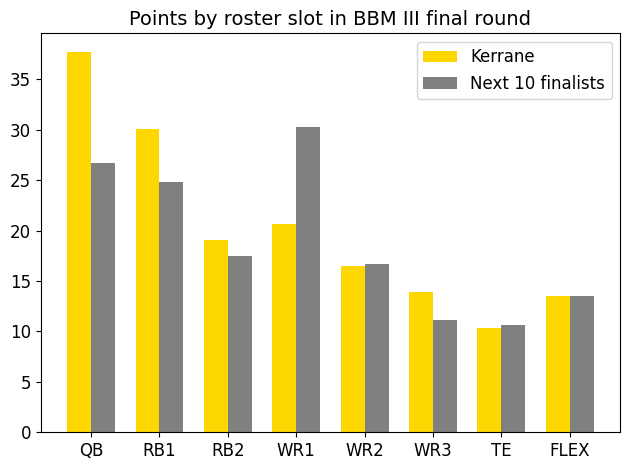

In [82]:


df_finals = df[(df['latest_rd']==4)&(df['optimal_17']==1)].reset_index(drop=True)
df_finals = pd.pivot_table(df_finals, values='score_17', index=['tournament_entry_id'], columns=['role_17'], aggfunc='first', fill_value=0)
df_finals['TOTAL_PTS'] = df_finals.sum(axis=1)
#df_finals = df_finals.reset_index().rename(columns={df_finals.index.name:'tournament_entry_id'})
df_finals = df_finals.sort_values(by=['TOTAL_PTS'], ascending=False).reset_index(drop=True)
df_finals = df_finals.iloc[:11, :].reset_index(drop=True)
df_finals['label'] = np.where(df_finals['TOTAL_PTS']==df_finals.at[0, 'TOTAL_PTS'], 'Kerrane', 'Next 10 finalists')
df_finals = df_finals.groupby(by=['label'], as_index=False).agg(
    QB = ('QB1', 'mean'), 
    RB1 = ('RB1', 'mean'), 
    RB2 = ('RB2', 'mean'), 
    WR1 = ('WR1', 'mean'), 
    WR2 = ('WR2', 'mean'), 
    WR3 = ('WR3', 'mean'), 
    TE = ('TE1', 'mean'), 
    FLEX = ('FLEX1', 'mean')
)

# Define the number of groups and the number of bars per group
num_groups = len(df_finals.columns[1:])
num_bars = len(df_finals)

# Define the width of the bars and the positions of the bars' centers on the x-axis
bar_width = 0.35
index = np.arange(num_groups)

# For each row in the DataFrame, add a bar to the plot
for i, row in df_finals.iterrows():
    color = 'gold' if row['label'] == 'Kerrane' else 'gray'
    plt.bar(index + i * bar_width, row[1:], bar_width, color=color, label=row['label'])

# Add labels and title with even larger font size
plt.title('Points by roster slot in BBM III final round', fontsize=14)
plt.xticks(index + bar_width / 2, df_finals.columns[1:], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})

# Display the plot
plt.tight_layout()
plt.show()

This chart compares Kerrane's lineup to an average of the scores for his 10 closest competitors in the final round of BBM III. It's clear that Pat's advantages at QB (Brady) and RB1 (Ekeler) helped him overcome a deficit at WR1 (Moore). He also had small edges at RB2 (Mostert) and WR3 (Thornton).

I would argue that Pat won because he had the highest possible score at two positions - QB and RB. While Pat's other stack pieces played critical roles by providing adequate scores, I'd say those outcomes were necessary but not sufficient for him to win.

# Recreation of Leone's simulated playoffs analysis

Luckily, we don't need to rely on just Pat's entry to make conclusions about the value of stacking. Mike Leone blazed a trail for stack analysis in his Best Ball Manifesto by simulating tournaments in each of the first 17 weeks of the NFL season. Let's attempt to recreate that analysis and see what we can learn about how stacks can help you win.

In [16]:
# Note run time for this block varies greatly, from 10 minutes to an hour
# Global variables
LATEST_ROUND = 1 # Minimum latest round
FIRST_WEEK = 1
LAST_WEEK = 17
NUM_TOP_SCORES = 1
TOP_SCORE_BUFFER = 0
TOP_SKILL_SCORES = 6
QB_ALLOWED = 3
winners = {'quarterfinals': 7520, 'semifinals': 4700, 'finals': 160}
top_pos = ['QB', 'RB', 'WR', 'TE']

# TODO: Name map
df['ud_name_pos'] = df['player_name']+"_"+df['position_name']
df['score_name_pos'] = df['ud_name_pos'].map(lambda x: dict_names.get(x,0)) 

# List of games by week
games = df_fpts.drop_duplicates(subset=['Team', 'Week', 'Opponent'], keep='first')
games = games.reset_index(drop=True)
games['team_week'] = games['Team'] + "_" + games['Week'].astype(str)
dict_games = dict(zip(games['team_week'], games['Opponent']))
del games

# Group main df by entry id to get scores by week
gb = df[df['latest_rd']>LATEST_ROUND].groupby(by=['tournament_entry_id'], as_index=False).agg(
    reg_season = ('pick_points', 'sum'),
    score_1 = ('score_1', 'sum'),
    score_2 = ('score_2', 'sum'),
    score_3 = ('score_3', 'sum'),
    score_4 = ('score_4', 'sum'),
    score_5 = ('score_5', 'sum'),
    score_6 = ('score_6', 'sum'),
    score_7 = ('score_7', 'sum'),
    score_8 = ('score_8', 'sum'),
    score_9 = ('score_9', 'sum'),
    score_10 = ('score_10', 'sum'),
    score_11 = ('score_11', 'sum'),
    score_12 = ('score_12', 'sum'),
    score_13 = ('score_13', 'sum'),
    score_14 = ('score_14', 'sum'),
    score_15 = ('score_15', 'sum'),
    score_16 = ('score_16', 'sum'),
    score_17 = ('score_17', 'sum'),
)

# Get probability of each entry winning tournaments of given size
for week in range(FIRST_WEEK,LAST_WEEK+1):
    print(f'Starting week {week}')
    # Update team for players if necessary
    df['score_name_pos_week'] = df['score_name_pos'] + "_" + str(week)
    df['temp_team'] = df['score_name_pos_week'].map(lambda x: dict_name_week.get(x, 0))
    df['team'] = np.where(df['temp_team']!=0, df['temp_team'], df['team'])
    df.drop(['temp_team','score_name_pos_week' ], axis=1)
    df['entry_team'] = df['tournament_entry_id']+"_"+df['team']
    
    # Add columns to 'gb' indicating winners of quarterfinals, semifinals, and finals
    # Then, create dictionaries from these columns
    gb['rank'] = gb[f'score_{week}'].rank(ascending=False, method='min')
    for round in winners:
        gb[round] = np.where(gb['rank']<=winners[round], 1, 0)
    dict_finals = dict(zip(gb['tournament_entry_id'], gb['finals']))
    dict_semifinals = dict(zip(gb['tournament_entry_id'], gb['semifinals']))
    dict_quarterfinals = dict(zip(gb['tournament_entry_id'], gb['quarterfinals']))
    
    # Identify highest scoring players for the week
    ranked_skill = np.sort(df[df['position_name'].isin(['WR', 'RB','TE'])][f'score_{week}'].unique())
    top_skill = ranked_skill[::-1][TOP_SKILL_SCORES-1]
    df_top_skill = df[df[f'score_{week}']>=top_skill].reset_index(drop=True)
    # Adjust if number of QBs in list of top players exceeds maximum allowed by global variable QB_ALLOWED
    if len(df_top_skill[df_top_skill['position_name']=='QB']['identifier'].unique()) > QB_ALLOWED:
        ranked_qb = np.sort(df_top_skill[df_top_skill['position_name']=='QB'][f'score_{week}'].unique())
        top_qb = ranked_qb[::-1][QB_ALLOWED-1]
        df_top_skill = df[((df['position_name']=='QB')&(df[f'score_{week}']>=top_qb))|((df['position_name'] != 'QB')&(df[f'score_{week}']>=top_skill))].reset_index(drop=True)
    df_top_skill = df_top_skill[['identifier', 'team', f'score_{week}', 'position_name']]
    df_top_skill['week'] = week
    df_top_skill['team_week'] = df_top_skill['team'] + "_" + str(week)
    df_top_skill['opponent'] = df_top_skill['team_week'].map(lambda x: dict_games.get(x, "BYE"))
    

    # Create table with each entry's position count by team
    gbt = df[df['latest_rd'] > LATEST_ROUND].groupby(by=['tournament_entry_id', 'team', 'position_name'], as_index=False).agg(
        count = ('identifier', 'count')
    )
    gbt['entry_team'] = gbt['tournament_entry_id'] + "_" + gbt['team']
    dict_entries = dict(zip(gbt['entry_team'], gbt['tournament_entry_id']))
    dict_teams = dict(zip(gbt['entry_team'], gbt['team']))
    team_cts = pd.pivot_table(gbt, values='count', index=['entry_team'], columns=['position_name'], aggfunc='sum', fill_value=0)
    team_cts = team_cts.reset_index().rename(columns={team_cts.index.name:'entry_team'})
    team_cts['tournament_entry_id'] = team_cts['entry_team'].map(dict_entries)
    team_cts['team'] = team_cts['entry_team'].map(dict_teams)
    team_cts['total'] = team_cts['QB'] + team_cts['RB'] + team_cts['WR'] + team_cts['TE']
    team_cts['PC'] = team_cts['WR'] + team_cts['TE']
    team_cts['total_skill'] = team_cts['RB'] + team_cts['WR'] + team_cts['TE']
    dict_opp_skill = dict(zip(team_cts['entry_team'], team_cts['total_skill']))
    dict_opp_RB = dict(zip(team_cts['entry_team'], team_cts['RB']))
    
    # Create table with each entry's team stacks
    df_stacks = team_cts[(team_cts['total']>1)].reset_index(drop=True) #& (team_cts['total']>team_cts['QB']) & (team_cts['total']>team_cts['RB'])].reset_index(drop=True) 
    df_stacks['team_week'] = df_stacks['team'] + '_' + str(week)
    df_stacks['opponent'] = df_stacks['team_week'].map(lambda x: dict_games.get(x, "BYE"))
    df_stacks['entry_opponent'] = df_stacks['tournament_entry_id'] + "_" + df_stacks['opponent']
    df_stacks['opponent_skill'] = df_stacks['entry_opponent'].map(lambda x: dict_opp_skill.get(x, 0))
    df_stacks['game_stack'] = np.where(df_stacks['opponent_skill']>0, 1, 0) 
    df_stacks['opponent_RB'] = df_stacks['entry_opponent'].map(lambda x: dict_opp_RB.get(x, 0))
    df_stacks['game_stack_skill'] = df_stacks['PC'] + np.where(df_stacks['entry_opponent'].isin(df_stacks[(df_stacks['QB']>0)&(df_stacks['PC']>0)]['entry_team']), 
        df_stacks['opponent_RB'], df_stacks['opponent_skill'])

    # Create table summarizing stacks by entry across all teams
    gb_stacks = df_stacks[(df_stacks['QB']>0)&(df_stacks['PC']>0)].groupby(by=['tournament_entry_id'], as_index=False).agg(
        #QB1 = ('QB1', 'sum'),
        QB = ('QB', 'sum'),
        PC = ('PC', 'sum'),
        #team_stack_PC1 = ('PC1', 'sum'),
        #PC2 = ('PC2', 'sum'),
        #opponent_QB1 = ('opponent_QB1', 'sum'),
        #opponent_PC1 = ('opponent_PC1', 'sum'),
        opponent_RB = ('opponent_RB', 'sum'),
        game_stack = ('game_stack', 'sum'),
        game_stack_skill = ('game_stack_skill', 'sum'),
        #game_stack_PC1 = ('game_stack_PC1', 'sum'),
        team_stack_ct = ('team', 'count'),
    )
    dict_team_stack_ct = dict(zip(gb_stacks['tournament_entry_id'], gb_stacks['team_stack_ct']))
    dict_game_stack = dict(zip(gb_stacks['tournament_entry_id'], gb_stacks['game_stack']))
    dict_game_stack_skill = dict(zip(gb_stacks['tournament_entry_id'], gb_stacks['game_stack_skill']))

    # TODO: EXPLAIN PC1
    pc1s = df[(df['latest_rd']>LATEST_ROUND)].reset_index(drop=True)
    pc1s['stack'] = np.where((pc1s['entry_team'].isin(df_stacks[(df_stacks['QB']>0)&(df_stacks['PC']>0)]['entry_team']))&(~pc1s['position_name'].isin(['RB'])),1,
                             np.where((pc1s['entry_team'].isin(df_stacks[(df_stacks['QB']>0)&(df_stacks['PC']>0)]['entry_opponent']))&(~pc1s['position_name'].isin(['QB'])), 1, 0))
    pc1s['finals'] = pc1s['tournament_entry_id'].map(dict_finals)
    pc1s['semifinals'] = pc1s['tournament_entry_id'].map(dict_semifinals)
    pc1s['quarterfinals'] = pc1s['tournament_entry_id'].map(dict_quarterfinals)
    pc1s['game_stack_skill'] = pc1s['tournament_entry_id'].map(lambda x: dict_game_stack_skill.get(x, 0))
    pc1s['team_stack_ct'] = pc1s['tournament_entry_id'].map(lambda x: dict_team_stack_ct.get(x, 0))
    pc1s['game_stack_ct'] = pc1s['tournament_entry_id'].map(lambda x: dict_game_stack.get(x, 0))
    pc1s['optimal_stack'] = pc1s['stack'] * pc1s[f'optimal_{week}']
    pc1s['optimal_stack_score'] = pc1s['stack'] * pc1s[f'optimal_{week}'] * pc1s[f'score_{week}']
    pc1s['week'] = week
    pc1s['top_skill_or_qb'] = pc1s[f'optimal_{week}'] * np.where(pc1s['identifier'].isin(df_top_skill['identifier'].unique()) & (pc1s[f'optimal_{week}']>0),1,0)
    pc1s['top_skill_qb'] = pc1s['top_skill_or_qb'] * np.where(pc1s['position_name']=='QB', 1, 0)
    pc1s['top_skill_rb'] = pc1s['top_skill_or_qb'] * np.where(pc1s['position_name']=='RB', 1, 0)
    pc1s['top_skill_wr'] = pc1s['top_skill_or_qb'] * np.where(pc1s['position_name']=='WR', 1, 0)
    pc1s['top_skill_te'] = pc1s['top_skill_or_qb'] * np.where(pc1s['position_name']=='TE', 1, 0)
    pc1s['team_week'] = pc1s['team'] + '_' + str(week)
    pc1s['opponent'] = pc1s['team_week'].map(lambda x: dict_games.get(x, "BYE"))
    pc1s['top_skill_stack'] = pc1s['top_skill_or_qb'] * pc1s['stack']
    #for pp in top_pos:
    #    pc1s[f'top_{pp}'] = pc1s['top_score'] * np.where(pc1s['position_name']==pp,1,0)

    # Get count of top skill or qb players from same game stack for each entry
    gbgs = pc1s[pc1s['top_skill_stack']==1].groupby(by=['entry_team'], as_index=False).agg(
        count = ('identifier', 'count')
    )
    dict_gbgs = dict(zip(gbgs['entry_team'], gbgs['count']))
    del gbgs
    pc1s['entry_opponent'] = pc1s['tournament_entry_id'] + "_" + pc1s['opponent']
    pc1s['top_skill_same_stack'] = np.where(pc1s['top_skill_stack']==0, 0, np.where(
        pc1s['entry_team'].map(lambda x: dict_gbgs.get(x, 0))>1, 1, np.where(
            pc1s['entry_opponent'].map(lambda x: dict_gbgs.get(x, 0))>0,1,0
        )
    ))
    gbgs_partial = pc1s[(pc1s['top_skill_or_qb']==1)&(pc1s['top_skill_stack']==0)].groupby(by=['entry_team'], as_index=False).agg(
        count = ('identifier', 'count')
    )
    dict_gbgs_partial = dict(zip(gbgs_partial['entry_team'], gbgs_partial['count']))
    pc1s['top_skill_same_partial_stack'] = np.where((pc1s['top_skill_or_qb']==0) | (pc1s['stack']==1), 0, np.where(
        pc1s['entry_team'].map(lambda x: dict_gbgs_partial.get(x, 0))>1, 1, np.where(
            pc1s['entry_opponent'].map(lambda x: dict_gbgs_partial.get(x, 0))>0,1,0
        )
    ))
    del dict_gbgs

    gb_optimal_stack_entry = pc1s.groupby(by=['tournament_entry_id', 'week'], as_index=False).agg(
        game_stack_skill = ('game_stack_skill', 'mean'),
        stack = ('stack', 'sum'),
        team_stack_ct = ('team_stack_ct', 'mean'),
        game_stack_ct = ('game_stack_ct', 'mean'),
        optimal_stack = ('optimal_stack', 'sum'),
        optimal_stack_score = ('optimal_stack_score', 'sum'),
        optimal_stack_score_max = ('optimal_stack_score', np.max),
        #top_scores = ('top_score', 'sum'),
        #top_score_stack = ('top_score_stack', 'sum'),
        #top_score_stack_binary = ('top_score_stack', np.max),
        #top_QB = ('top_QB', 'sum'),
        #top_RB = ('top_RB', 'sum'),
        #top_WR = ('top_WR', 'sum'),
        #top_TE = ('top_TE', 'sum'),
        top_skill_or_qb = ('top_skill_or_qb', 'sum'),
        top_skill_qb = ('top_skill_qb', 'sum'),
        top_skill_rb = ('top_skill_rb', 'sum'),
        top_skill_wr = ('top_skill_wr', 'sum'),
        top_skill_te = ('top_skill_te', 'sum'),
        finals = ('finals', 'mean'),
        semifinals = ('semifinals', 'mean'),
        quarterfinals = ('quarterfinals', 'mean'),
        #game_stack_adp = ('game_stack_adp', 'sum'),
        #top_skill_adp = ('top_skill_adp', 'sum'),
        top_skill_stack = ('top_skill_stack', 'sum'),
        top_skill_same_stack = ('top_skill_same_stack', 'sum'),
        top_skill_same_partial_stack = ('top_skill_same_partial_stack', 'sum'),
        #top_skill_unstacked_first = ('top_skill_unstacked_first', 'sum'),
        #top_skill_unstacked_second = ('top_skill_unstacked_second', 'sum'),
        )
    gb_optimal_stack_entry['top_skill_same_stack_binary'] = np.where(gb_optimal_stack_entry['top_skill_same_stack'] > 0 , 1, 0)
    gb_optimal_stack_entry['top_skill_stack_binary'] = np.where(gb_optimal_stack_entry['top_skill_stack'] > 0 , 1, 0)
    gb_optimal_stack_entry['top_skill_same_partial_stack_binary'] = np.where((gb_optimal_stack_entry['top_skill_stack'] == 0) & (gb_optimal_stack_entry['top_skill_same_partial_stack'] > 0) , 1, 0)
    if week == FIRST_WEEK:
        gb_optimal_stack_entry_output = gb_optimal_stack_entry
        df_top_skill_output = df_top_skill

    else:
        gb_optimal_stack_entry_output = pd.concat([gb_optimal_stack_entry_output, gb_optimal_stack_entry])
        df_top_skill_output = pd.concat([df_top_skill_output, df_top_skill])

# TODO: Explain output
gb_top_skills_stack_summary = gb_optimal_stack_entry_output.groupby(by=['game_stack_skill', 'top_skill_or_qb'], as_index=False).agg(
    count = ('tournament_entry_id', 'count'),
    stack = ('stack', 'mean'),
    team_stack_ct = ('team_stack_ct', 'mean'),
    game_stack_ct = ('game_stack_ct', 'mean'),
    top_skill_qb = ('top_skill_qb', 'mean'),
    top_skill_rb = ('top_skill_rb', 'mean'),
    top_skill_wr = ('top_skill_wr', 'mean'),
    top_skill_te = ('top_skill_te', 'mean'),
    finals = ('finals', 'sum'),
    semifinals = ('semifinals', 'sum'),
    quarterfinals = ('quarterfinals', 'sum'),
    top_skill_stack = ('top_skill_stack', 'mean'),
    top_skill_same_stack = ('top_skill_same_stack', 'mean'),
    top_skill_same_stack_binary = ('top_skill_same_stack_binary', 'mean'),
    top_skill_same_partial_stack = ('top_skill_same_partial_stack', 'mean'),
    top_skill_same_partial_stack_binary = ('top_skill_same_partial_stack_binary', 'mean'),
    top_skill_stack_binary = ('top_skill_stack_binary', 'mean'),
)
gb_top_skills_stack_summary['finals_pct'] = gb_top_skills_stack_summary['finals'] / gb_top_skills_stack_summary['count']
gb_top_skills_stack_summary['semifinals_pct'] = gb_top_skills_stack_summary['semifinals'] / gb_top_skills_stack_summary['count']
gb_top_skills_stack_summary['quarterfinals_pct'] = gb_top_skills_stack_summary['quarterfinals'] / gb_top_skills_stack_summary['count']

Starting week 1
Starting week 2
Starting week 3
Starting week 4
Starting week 5
Starting week 6
Starting week 7
Starting week 8
Starting week 9
Starting week 10
Starting week 11
Starting week 12
Starting week 13
Starting week 14
Starting week 15
Starting week 16
Starting week 17


In [83]:
stack_cts = gb_top_skills_stack_summary.groupby(by=['game_stack_skill'], as_index=False).agg(
    count = ('count', 'sum')
)
stack_cts['Pct of all entries'] = stack_cts['count'] / sum(stack_cts['count'])
stack_cts['Pct of all entries'] = stack_cts['Pct of all entries'].round(2)
stack_cts['Pct of all entries'] = stack_cts['Pct of all entries'].astype(str)
stack_cts['Pct of all entries'] = np.where(stack_cts['Pct of all entries']=='0.0', '<0.01', stack_cts['Pct of all entries'])
stack_cts['count'] = stack_cts['count'].astype(str)
stack_cts = stack_cts.rename(columns={'count': 'Number of entries'})

stack_cts = stack_cts.T
stack_cts.loc[len(stack_cts.index)] = ['0.14', '0.16', '0.20', '0.20', '0.16', '0.10', '0.04', '0.02', '<0.01', '<0.01', '<0.01', '<0.01', 'NA']
stack_cts = stack_cts.rename(index={3:'Leone pct of all entries'})
stack_cts = stack_cts.iloc[1:,:]
print('Breakdown of entries in simulated 17 weeks of tournaments by number of team or game-stacked players')
stack_cts

Breakdown of entries in simulated 17 weeks of tournaments by number of team or game-stacked players


,0,1,2,3,4,5,6,7,8,9,10,11,12
Number of entries,172668,206036,266747,252979,192914,112813,50108,17834,4867,1142,258,26,8
Pct of all entries,0.14,0.16,0.21,0.2,0.15,0.09,0.04,0.01,<0.01,<0.01,<0.01,<0.01,<0.01
Leone pct of all entries,0.14,0.16,0.20,0.20,0.16,0.10,0.04,0.02,<0.01,<0.01,<0.01,<0.01,NA


The code above simulates playoff rounds similar to the BBM III quarterfinals, semifinals, and finals for the first 17 weeks of the 2022 NFL season. This analysis takes the 75,200 entries that advanced out of the regular season of BBM III, ranks the score of their optimal lineup each week, and defines winners as the top 10% for quarterfinals, top 6.25% for semifinals, and top 0.21% for finals. 

I first want to determine how well my process approximates Leone's. The table above shows the breakdown of entries by number of team or game-stacked players. My breakdown is very similar to Leone's, with some small exceptions. 

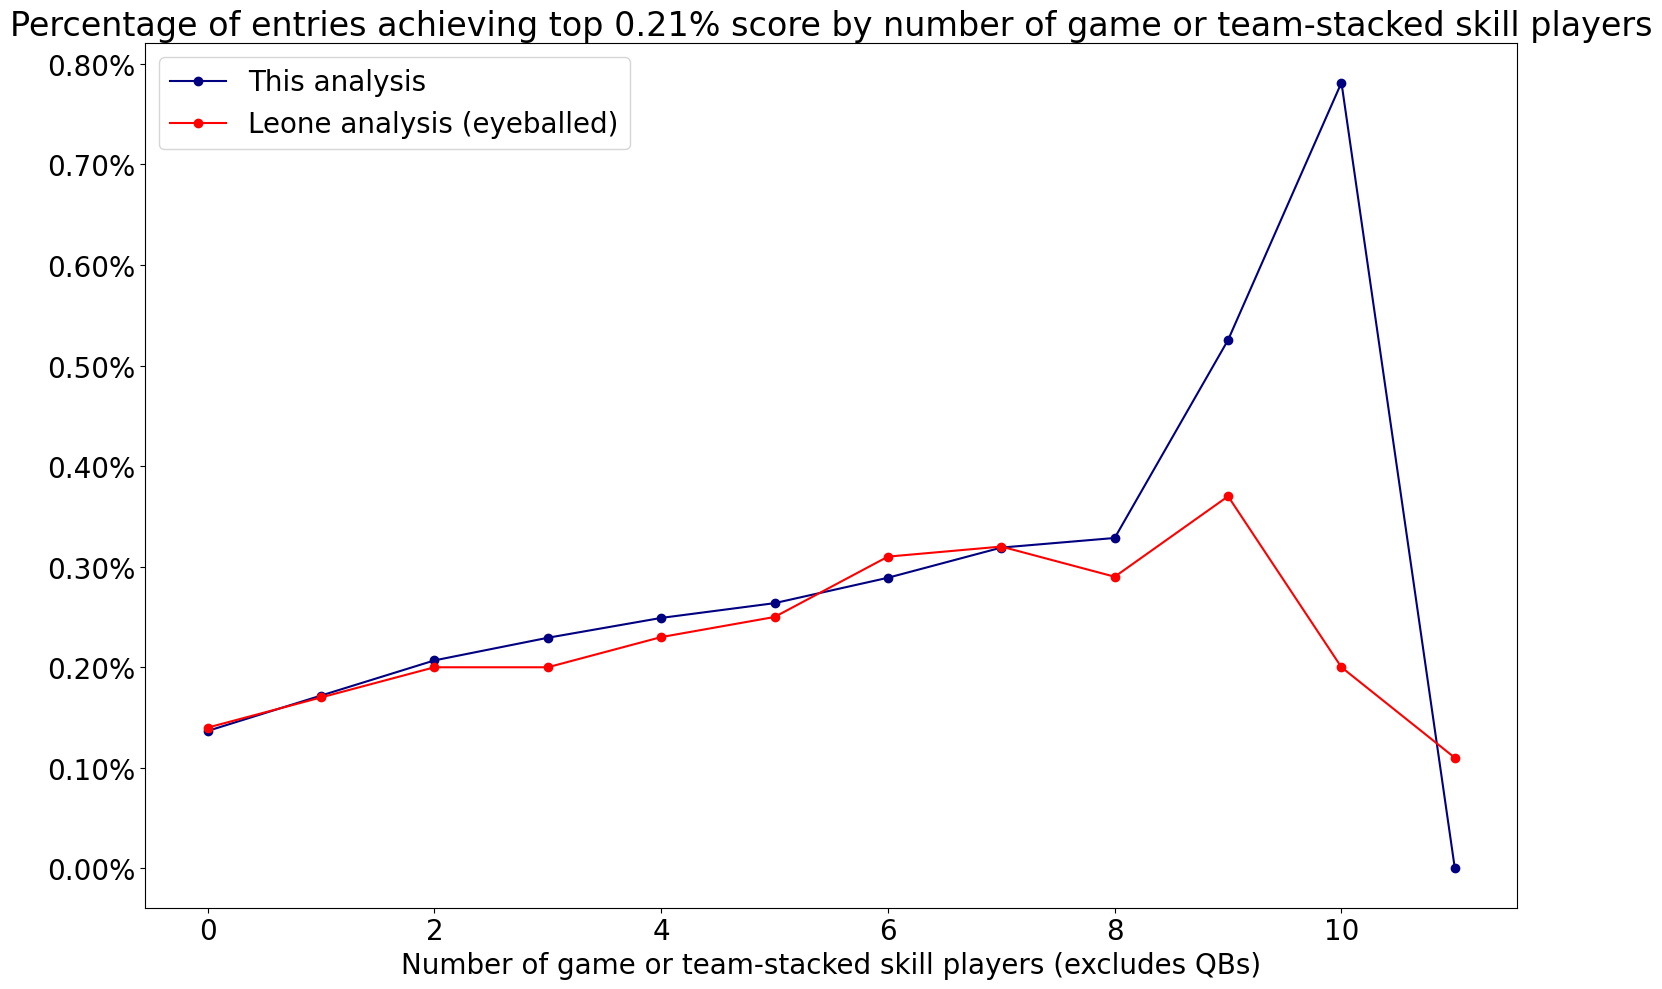

In [76]:
# Group df_new by 'game_stack_skill' and sum 'count' and 'count_times_weighted_average'
grouped_df_new = gb_top_skills_stack_summary.groupby('game_stack_skill')[['count', 'finals']].sum()

# Create a new column 'implied_win_pct' by dividing the summed 'count_times_weighted_average' by the summed 'count'
grouped_df_new['finals_win_pct'] = grouped_df_new['finals'] / grouped_df_new['count']

# Create a DataFrame for the Leone estimate
leone_estimate = pd.DataFrame({'game_stack_skill': list(range(0, 12)), 
                               'leone_estimate': [0.0014, 0.0017, 0.0020, 0.0020, 0.0023, 0.0025, 0.0031, 0.0032, 0.0029, 0.0037, 0.0020, 0.0011]})
leone_estimate.set_index('game_stack_skill', inplace=True)

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot 'finals_win_pct' as a line plot with navy color and point markers
grouped_df_new['finals_win_pct'].iloc[:-1].plot(kind='line', color='navy', marker='o', ax=ax, label='This analysis')

# Plot 'leone_estimate' as a line plot with red color and point markers
leone_estimate['leone_estimate'].plot(kind='line', color='red', marker='o', ax=ax, label='Leone analysis (eyeballed)')

# Add title
ax.set_title('Percentage of entries achieving top 0.21% score by number of game or team-stacked skill players', fontsize=24)

# Format y-axis as percentage with 2 decimal places
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))

# Increase the size of x-axis and y-axis labels
ax.tick_params(axis='both', which='major', labelsize=20)

# Remove the y-axis title and add x-axis label
ax.set_ylabel('')
ax.set_xlabel('Number of game or team-stacked skill players (excludes QBs)', fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Display the plot
plt.tight_layout()
plt.show()


This chart compares the 'finals win rate' by stack size for my analysis vs Leone's results, which I eyeballed from his chart. Our win rates are extremely close through 8 stacked players - entries with 0 through 8 stacked players comprise 99.9% of all entries in my analysis.

However, my estimates are much higher for 9 and 10 stacked players and I don't know why. Given the complexity of this analysis and number of assumptions it requires, I don't think I could replicate Leone's work without seeing his code. However, I will note that a 0.8% win rate for the 256 entries in the 10-player stack bucket equates to just 2 winners, so we're talking about an extremely small and sensitive sample whose win rate could fluctuate with small changes to the methodologies.

I am fine proceeding with my analysis despite my variances to Leone's estimates for the 9 and 10 player buckets because (1) the entries in these buckets are a tiny fraction of the total, and (2) these values are not central to my thesis and conclusions below.

# Top scoring players

My goal is to determine whether stacks add value to lineups by increasing access to top scoring players in a given week, so I first need to define this cohort. There's no perfect way to do this, so I'll lay out my choices below, but know that I've run this analysis with different definitions and the story doesn't change.

I defined top scorers as the combination of:
1. The 6 skill players (RB, WR, TE) with the highest weekly scores
2. Up to 3 QBs with scores higher than the 6th-highest skill player from #1

Why 6? I wanted to keep this number small but also account for weeks when a lot of players pop off. I tested a range from 4 to 12 here and found 6 seemed like a good balance. 

Why only 3 QBs? If you just take the top N scoring players in a week, that list will likely be dominated by QBs. That's not ideal if your goal is to identify players driving playoff win rates, especially since optimal rosters include just 1 QB. On the other hand, QBs are key to stacks. I tested a range of values here and, like the above, found that 3 QBs seemed like a well-balanced choice.

In [83]:
# Isolate week 3 top scoring players to use as an example
df_top_skill_3 = df_top_skill_output[df_top_skill_output['week']==3]['identifier'].unique()
df_fpts_3 = df_fpts[df_fpts['Week']==3].reset_index(drop=True)
df_fpts_3 = df_fpts_3.sort_values(by=['FantasyPointsFanDuel'], ascending=False).reset_index(drop=True)
df_fpts_3 = df_fpts_3.loc[:10, :]
df_fpts_3['identifier'] = df_fpts_3.Name.map(lambda y: y.replace('.',''))
df_fpts_3['identifier'] = df_fpts_3.identifier.map(lambda z: z.replace(' ', '_'))
df_fpts_3['identifier'] = df_fpts_3['Position'] + "_" + df_fpts_3['identifier'] + "_" + df_fpts_3['Team']
df_fpts_3['Included?'] = np.where(df_fpts_3['identifier'].isin(df_top_skill_3), "Yes", "No")
df_fpts_3 = df_fpts_3.rename(columns={'FantasyPointsFanDuel': 'Points'})
df_fpts_3 = df_fpts_3[['Name', 'Position', 'Team', 'Points', 'Included?']]
print('Top scoring players in week 3 of 2022 NFL season, sorted by points')
df_fpts_3


Top scoring players in week 3 of 2022 NFL season


,Name,Position,Team,Points,Included?
0,Lamar Jackson,QB,BAL,40.42,Yes
1,Khalil Herbert,RB,CHI,29.90,Yes
2,Jalen Hurts,QB,PHI,27.60,Yes
3,DeVonta Smith,WR,PHI,26.90,Yes
4,Josh Allen,QB,BUF,26.70,Yes
5,Mack Hollins,WR,LV,25.96,Yes
6,Trevor Lawrence,QB,JAX,25.18,No
7,Mark Andrews,TE,BAL,24.90,Yes
8,Jamaal Williams,RB,DET,23.70,Yes
9,Joe Burrow,QB,CIN,23.00,No


As an example, this table shows the top scoring players in week 3 of the 2022 NFL season. The 'Included?' column indicates whether the player would be included in the list of the top scorers I use in my analysis. Note that 2 QBs (Lawrence and Burrow) have scores higher than Derrick Henry but they are excluded since Lamar, Jalen, and Josh take up the 3 QB spots.

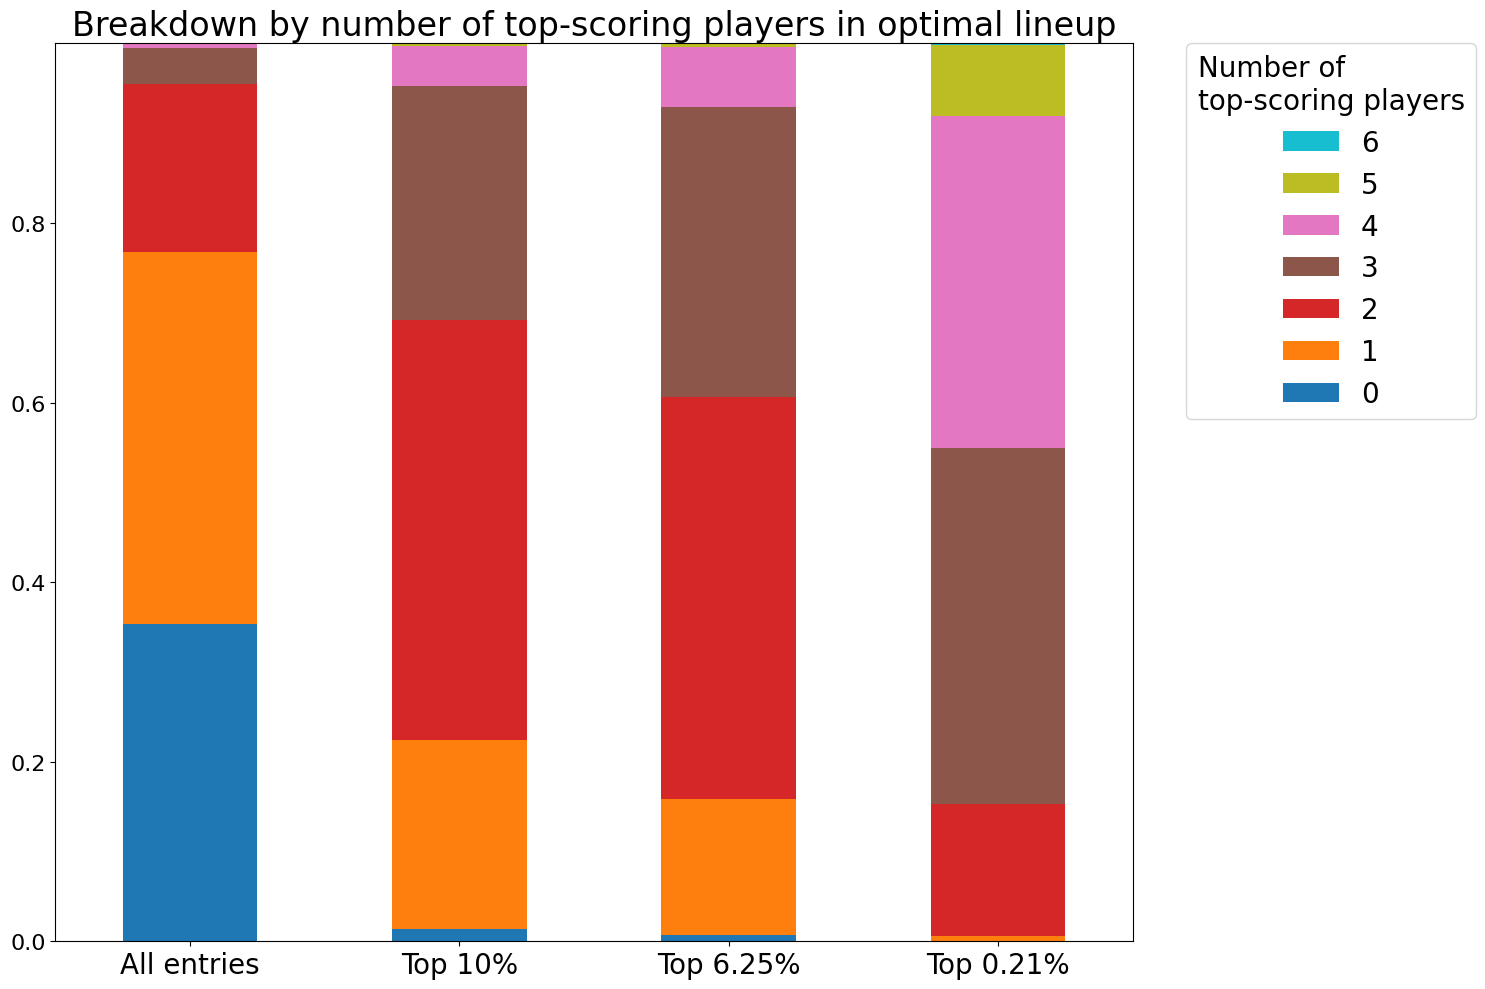

In [98]:
# Create a new DataFrame with the sum of 'finals_winners', 'quarterfinals_winners', and 'semifinals_winners' for each 'top_skill_or_qb'
grouped_df = gb_top_skills_stack_summary.groupby('top_skill_or_qb')[['count', 'finals', 'quarterfinals', 'semifinals']].sum()

# Transpose the DataFrame to have 'finals_winners', 'quarterfinals_winners', and 'semifinals_winners' as rows instead of columns
grouped_df = grouped_df.transpose()

# Normalize the DataFrame to represent proportions instead of raw counts
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

# Reorder the DataFrame rows
grouped_df = grouped_df.reindex(['count', 'quarterfinals', 'semifinals', 'finals'])

# Plot the DataFrame as a vertical stacked bar plot with reversed color map
ax = grouped_df.plot(kind='bar', stacked=True, colormap='tab10', figsize=(15,10))

# Reverse the order of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title='Number of\ntop-scoring players', title_fontsize='20', fontsize='20', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Add labels and title
plt.title("Breakdown by number of top-scoring players in optimal lineup", fontsize=24)
plt.yticks(fontsize=16)

# Change labels of each bar, rotate them to horizontal, and increase their font size
ax.set_xticklabels(['All entries', 'Top 10%', 'Top 6.25%', 'Top 0.21%'], rotation=0, fontsize=20)

# Remove the x-axis title
ax.set_xlabel('')

# Display the plot
plt.tight_layout()
plt.show()

Turns out having these top scorers is very important, especially to win a BBM finals-sized contest. 80% of all entries in our sim had 0 or 1 of these top scorers - almost none of these entries achieved even a top 10% score. Most top 10% and top 6.25% entries had 2 or 3 of these players. But finals-sized contests are completely different than these first two rounds - most top 0.21% scores had 3 or 4 top scorers.

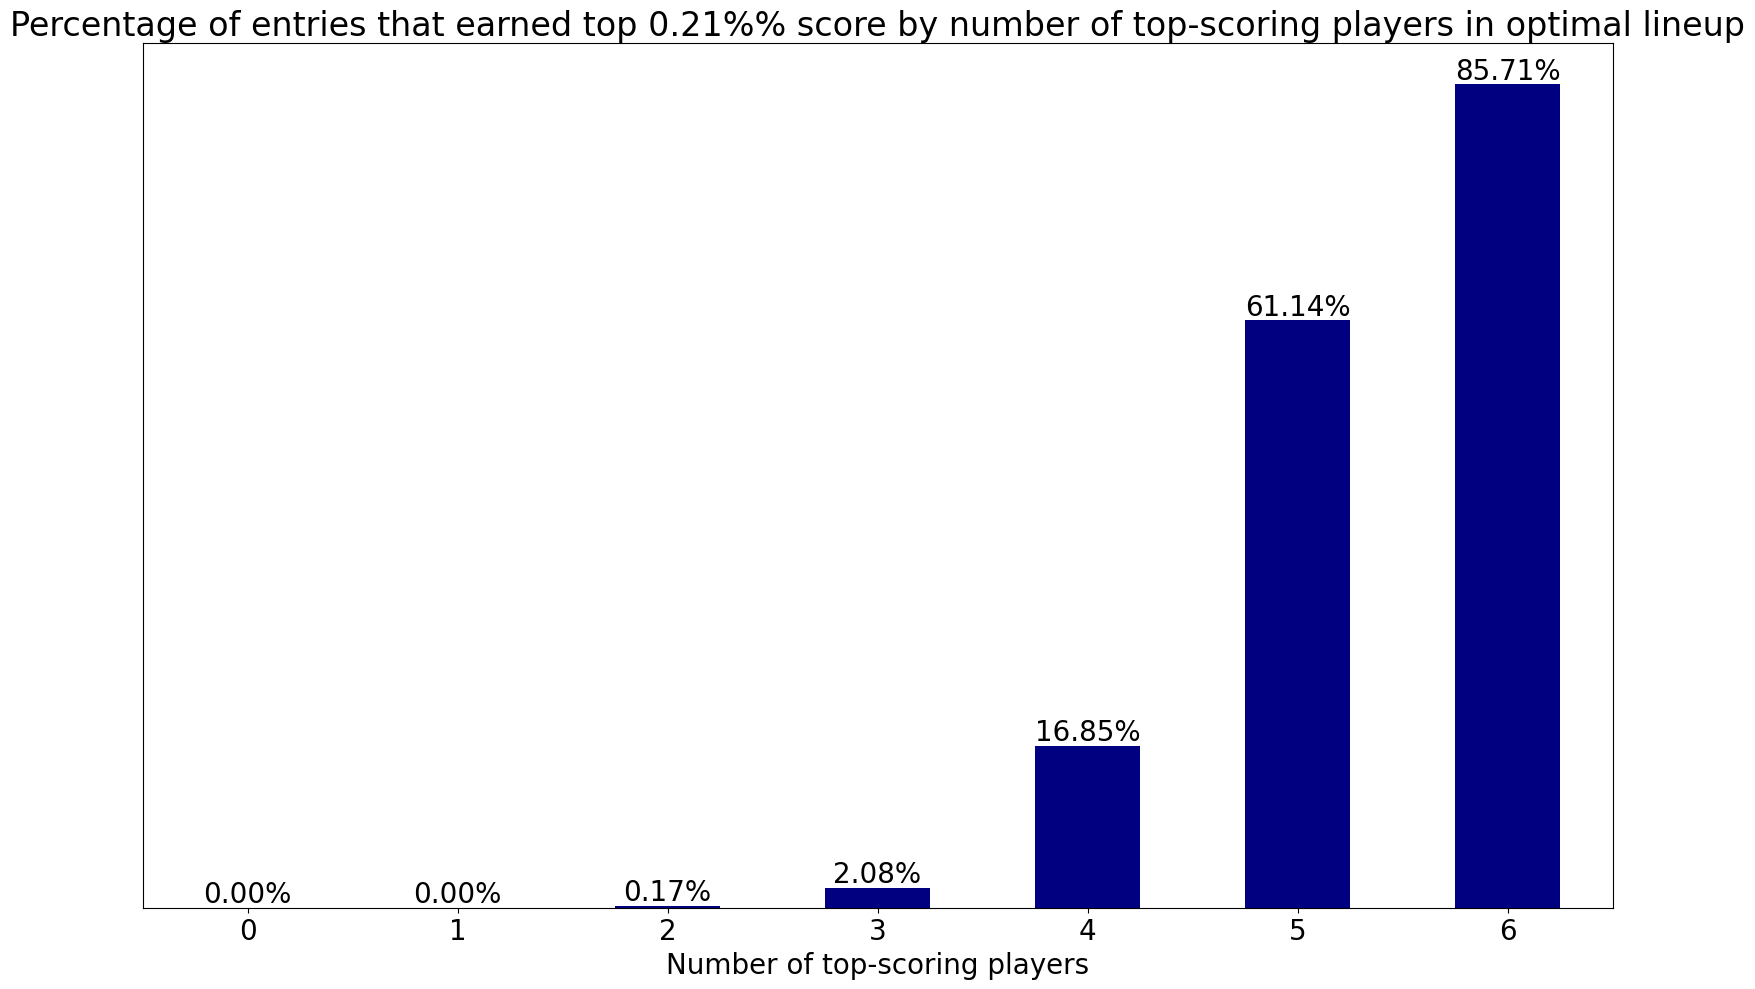

In [86]:
# Calculate the sum of 'finals_winners' and 'count' for each value of 'top_skill_or_qb'
summed_df = gb_top_skills_stack_summary.groupby('top_skill_or_qb')[['finals', 'count']].sum()

# Calculate the weighted average of 'finals' by dividing the summed 'finals_winners' by the summed 'count'
summed_df['weighted_average_finals'] = summed_df['finals'] / summed_df['count']

# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the 'weighted_average_finals' as a bar plot with navy color
ax = summed_df['weighted_average_finals'].plot(kind='bar', color='navy')

# Add data labels formatted as percentages with two decimal places
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=20)

# Remove the y-axis and its labels
ax.get_yaxis().set_visible(False)

# Add title
ax.set_title('Percentage of entries that earned top 0.21%% score by number of top-scoring players in optimal lineup', fontsize=24)

# Add x-axis label and increase its size
ax.set_xlabel('Number of top-scoring players', fontsize=20)

# Increase the size of x-axis labels and remove rotation
ax.set_xticklabels(summed_df.index, rotation=0, fontsize=20)

# Display the plot
plt.tight_layout()
plt.show()


Looking at win rate just for a finals-sized contest, we see that having more top scorers drastically increases the likelihood of a top 0.21% score. Entries with 3 top scorers had a 10x likelihood of winning vs baseline, while entries with 4 had an 80x increase. This on its own isn't revelatory - having the top scorers should increase your odds of winning. So let's look at how this connects with stacking.

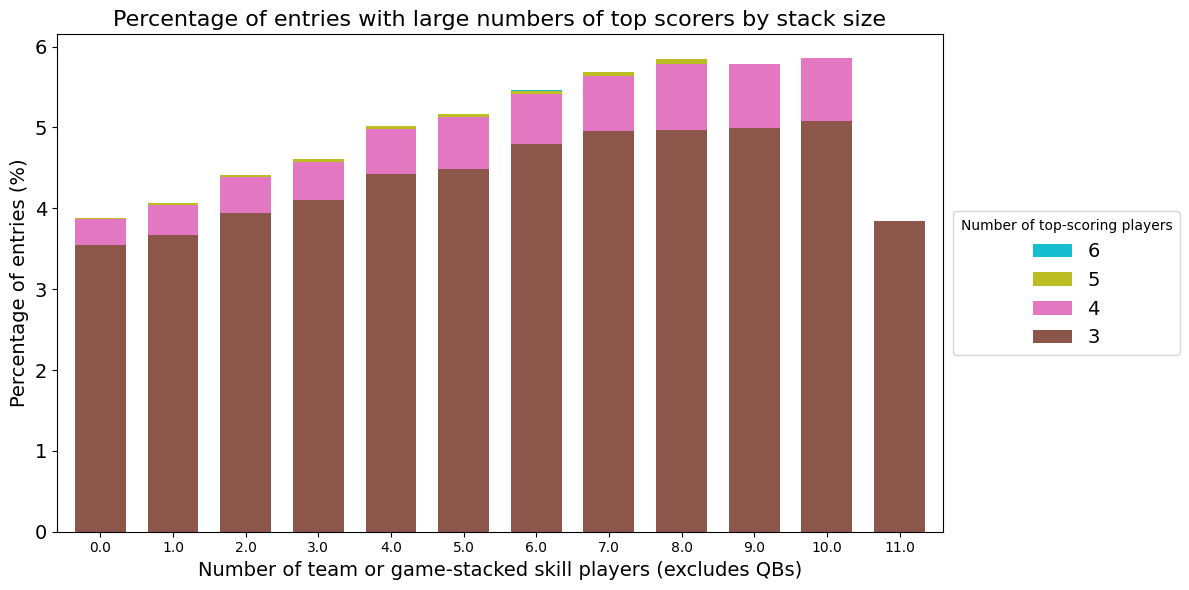

In [108]:

# Define a function to convert y-axis values to percentages
def to_percent(y, position):
    return str(int(y * 100))

# Pivot the data to create the required structure for the stacked column chart
df_pivot = gb_top_skills_stack_summary.pivot(index='game_stack_skill', columns='top_skill_or_qb', values='count')

# Normalize the values to create a stacked chart
df_pivot_percentage = df_pivot.div(df_pivot.sum(axis=1), axis=0)

# Exclude 'top_skill_or_qb' equals 0, 1, 2 and 12
df_pivot_percentage_excluded = df_pivot_percentage.drop(columns=[0, 1, 2]).drop(index=[12])

# Customize the colors for the different stacks
colors_dict = {3: '#8c564b',  # brown
               4: '#e377c2',  # pink
               5: '#bcbd22',  # lime green
               6: '#17becf'}  # turquoise

# Plot the stacked column chart with the customized colors
ax = df_pivot_percentage_excluded.plot(kind='bar', stacked=True, figsize=(12, 6), color=[colors_dict[i] for i in df_pivot_percentage_excluded.columns], width=0.7)

# Add labels and title
plt.xlabel('Number of team or game-stacked skill players (excludes QBs)', fontsize=14)
plt.ylabel('Percentage of entries (%)', fontsize=14)
plt.title('Percentage of entries with large numbers of top scorers by stack size', fontsize=16)

# Rotate the labels on the x-axis and round them to zero digits
ax.set_xticklabels(df_pivot_percentage_excluded.index, rotation=0)

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

# Increase the font size of the y-axis tick labels and legend
plt.yticks(fontsize=14)

# Exclude 0, 1, and 2 from the legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[i] for i in range(len(handles)) if labels[i] not in ['0', '1', '2']]
labels = [label for label in labels if label not in ['0', '1', '2']]

plt.legend(handles[::-1], labels[::-1], title='Number of top-scoring players', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


This chart shows the percentage of entries in each stack size bucket that rostered 3+ top scorers, since most top 0.21% lineups had 3+ of these players. You can see that the probability increases steadily with stack size until bucket 8. The total increase may seem small, but the chart below shows it's extremely impactful. 

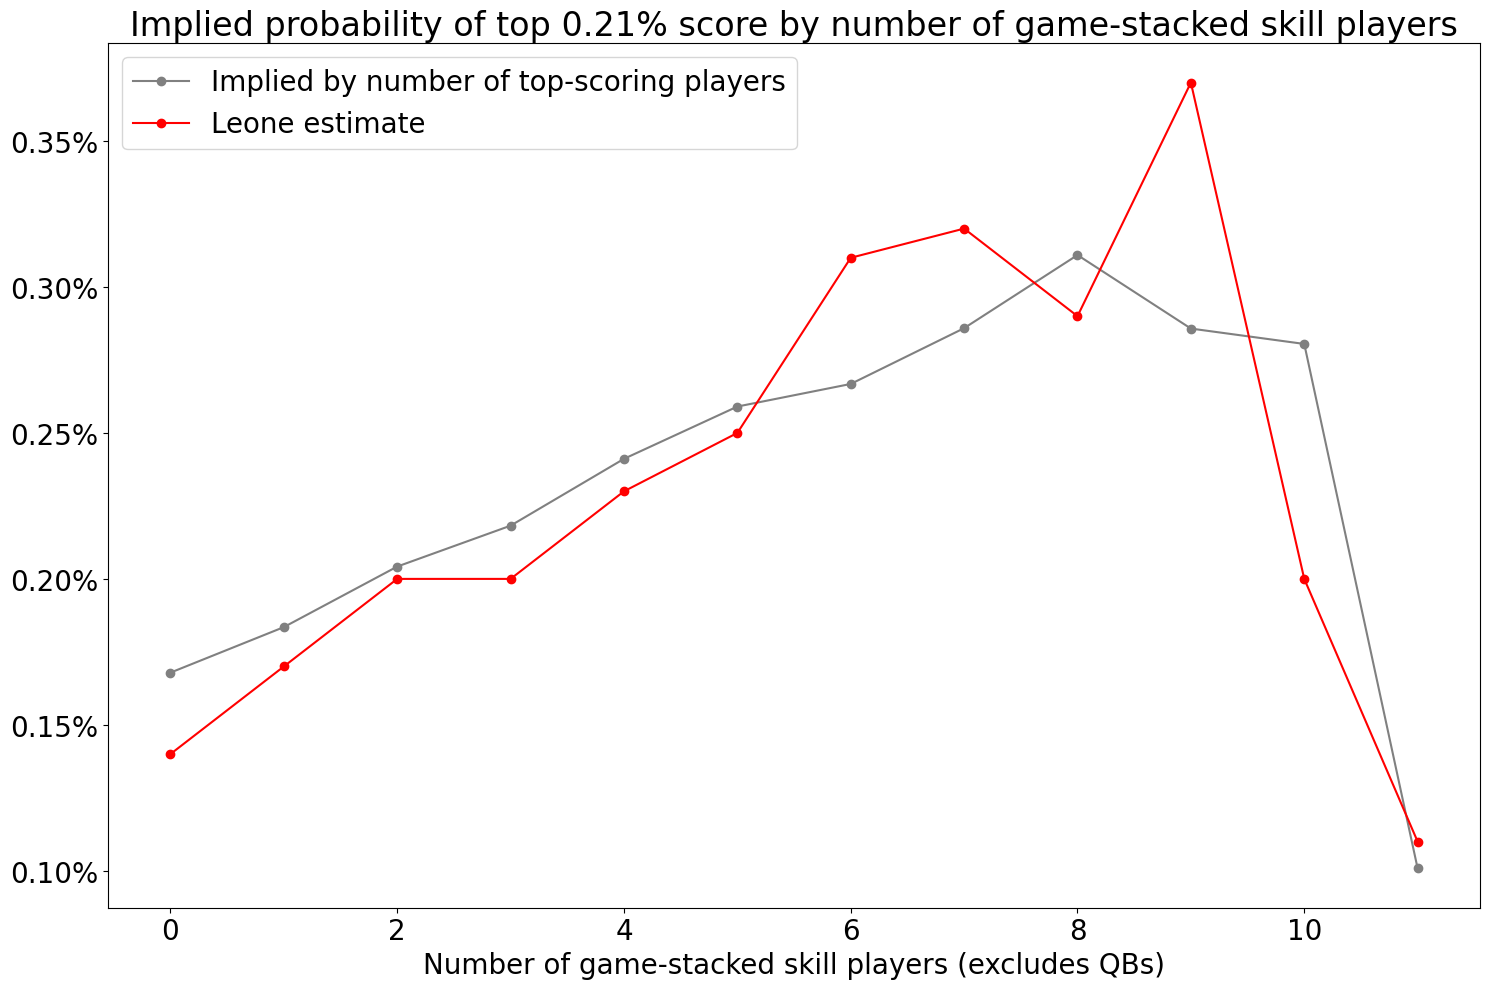

In [87]:
# Create a new column that is the product of 'count' and the mapped value of 'weighted_average_finals'
gb_top_skills_stack_summary['count_times_weighted_average'] = gb_top_skills_stack_summary['count'] * gb_top_skills_stack_summary['top_skill_or_qb'].map(summed_df['weighted_average_finals'])

# Group df_new by 'game_stack_skill' and sum 'count' and 'count_times_weighted_average'
grouped_df_new = gb_top_skills_stack_summary.groupby('game_stack_skill')[['count', 'count_times_weighted_average']].sum()


# Create a new column 'implied_win_pct' by dividing the summed 'count_times_weighted_average' by the summed 'count'
grouped_df_new['implied_win_pct'] = grouped_df_new['count_times_weighted_average'] / grouped_df_new['count']

# Create a DataFrame for the Leone estimate
leone_estimate = pd.DataFrame({'game_stack_skill': list(range(0, 12)), 
                               'leone_estimate': [0.0014, 0.0017, 0.0020, 0.0020, 0.0023, 0.0025, 0.0031, 0.0032, 0.0029, 0.0037, 0.0020, 0.0011]})
leone_estimate.set_index('game_stack_skill', inplace=True)


# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot 'implied_win_pct' as a line plot with navy color and point markers
grouped_df_new['implied_win_pct'].iloc[:-1].plot(kind='line', color='gray', marker='o', ax=ax, label='Implied by number of top-scoring players')

# Plot 'leone_estimate' as a line plot with red color and point markers
leone_estimate['leone_estimate'].plot(kind='line', color='red', marker='o', ax=ax, label='Leone estimate')

# Add title
ax.set_title('Implied probability of top 0.21% score by number of game-stacked skill players', fontsize=24)

# Format y-axis as percentage with 2 decimal places
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))

# Increase the size of x-axis and y-axis labels
ax.tick_params(axis='both', which='major', labelsize=20)

# Remove the y-axis title and add x-axis label
ax.set_ylabel('')
ax.set_xlabel('Number of game-stacked skill players (excludes QBs)', fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Display the plot
plt.tight_layout()
plt.show()



The red line here is the same line for Leone's estimated finals win rates by stack size that we saw above. The gray line is what I calculated by taking each stack bucket's breakdown by number of top scorers (0-6) and the finals win rate achieved by entries with that many top scorers. So it's essentially the win rate we'd predict if all we knew about each bucket was its top scorer mix.

This prediction closely tracks the actual win rates estimated by Leone. This suggests that much of the value of larger stacks can be attributed to their higher likelihood of having 3+ top scorers.

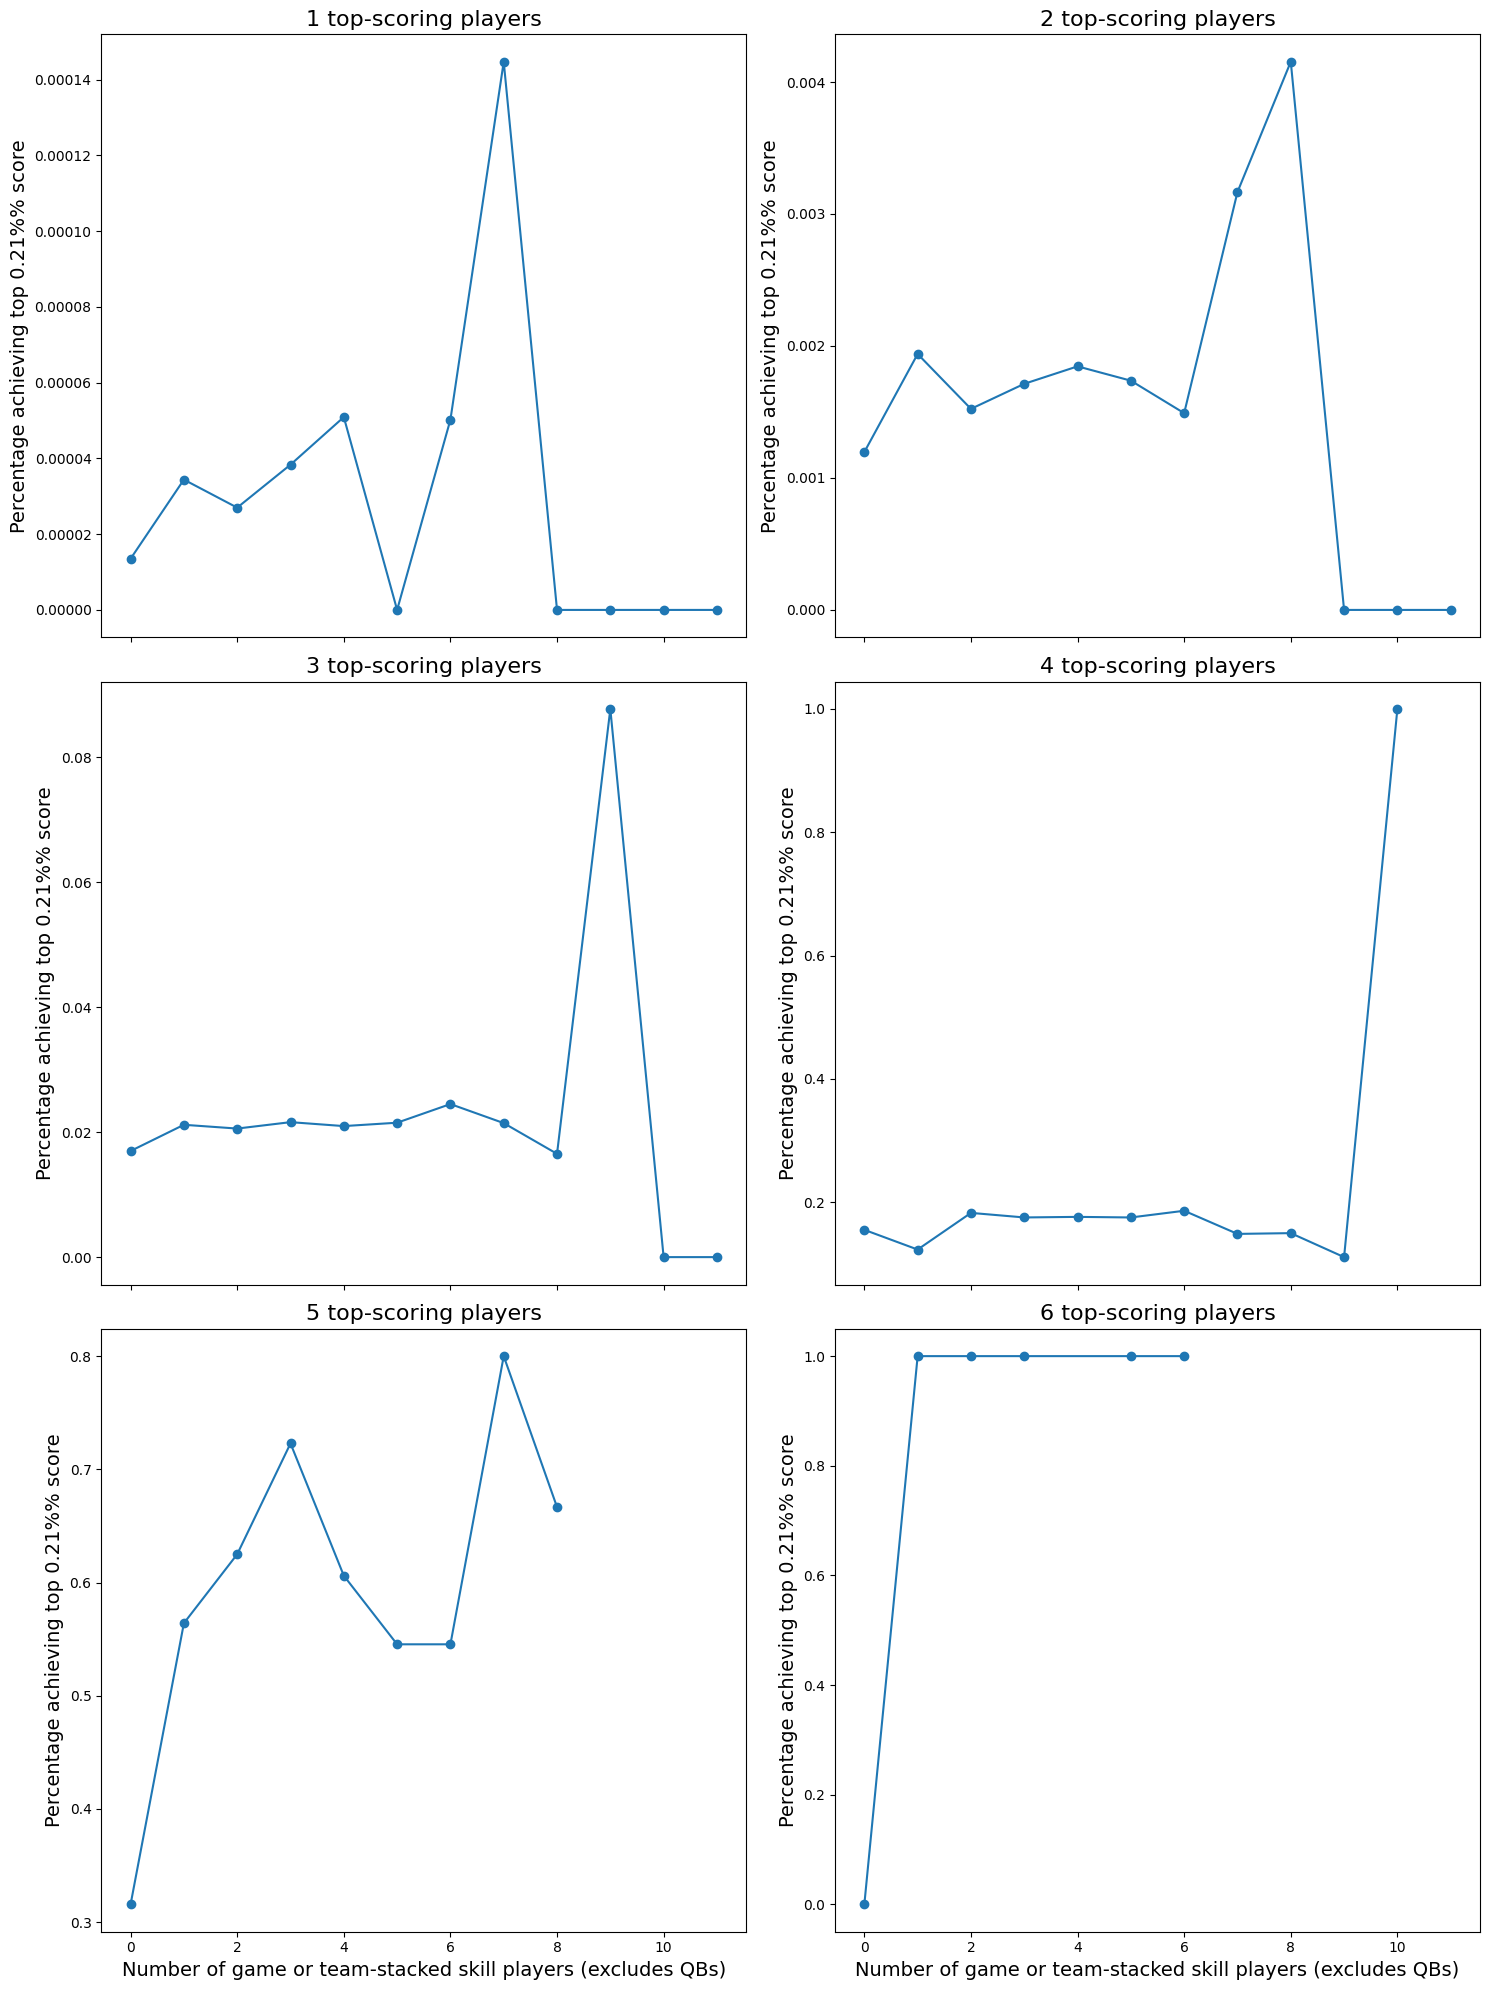

In [114]:
# Exclude the 'top_skill_or_qb' equals 0
df_new_excluded = gb_top_skills_stack_summary[(gb_top_skills_stack_summary['top_skill_or_qb'] != 0) &
                                              (gb_top_skills_stack_summary['game_stack_skill'] < 12) ]

# Create a grid of subplots with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(15, 20), sharex=True)

# Flatten the axes array to make it one-dimensional for easy iteration
axs = axs.flatten()

# Loop through each unique value of 'top_skill_or_qb'
for idx, val in enumerate(sorted(df_new_excluded['top_skill_or_qb'].unique())):
    # Filter df_new for the current 'top_skill_or_qb' value
    df_filtered = df_new_excluded[df_new_excluded['top_skill_or_qb'] == val]
    
    # Plot 'finals' as a line plot for the filtered DataFrame on the current subplot
    df_filtered.plot(x='game_stack_skill', y='finals_pct', kind='line', ax=axs[idx], legend=False, marker='o')
    
    # Add a title to the subplot indicating the 'top_skill_or_qb' value
    axs[idx].set_title(f'{val} top-scoring players', fontsize=16)
    
    # Add labels to the x-axis and y-axis
    axs[idx].set_xlabel('Number of game or team-stacked skill players (excludes QBs)', fontsize=14)
    axs[idx].set_ylabel('Percentage achieving top 0.21%% score', fontsize=14)
    
    # Allow each subplot to have its own y-axis range
    axs[idx].autoscale()

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


Another way of looking at the same concept - this plots finals win rate by stack size for entries with 1 through 6 top scorers. These lines are mostly flat or choppy, which suggests that there may be little value to larger stacks after accounting for top scorers. However, this is not a definitive analysis and I think future work will likely uncover more nuance in the relationship between stacking and win rate.

<Figure size 1000x600 with 0 Axes>

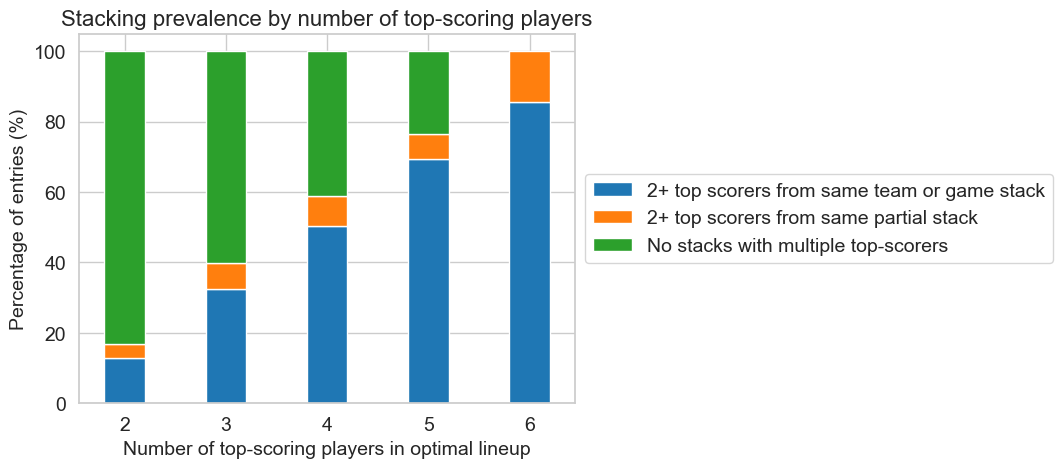

In [136]:


# Create new columns for 'same_stack_entries', 'partial_stack_entries', and 'no_stacks'
gb_top_skills_stack_summary['same_stack_entries'] = gb_top_skills_stack_summary['count'] * gb_top_skills_stack_summary['top_skill_same_stack_binary']
gb_top_skills_stack_summary['partial_stack_entries'] = gb_top_skills_stack_summary['count'] * gb_top_skills_stack_summary['top_skill_same_partial_stack_binary']
gb_top_skills_stack_summary['no_stacks'] = gb_top_skills_stack_summary['count'] - gb_top_skills_stack_summary['same_stack_entries'] - gb_top_skills_stack_summary['partial_stack_entries']

# Set style
sns.set(style="whitegrid")

# Group the data by 'top_skill_or_qb' and calculate the sum for each group
grouped_data = gb_top_skills_stack_summary.groupby('top_skill_or_qb').agg({'same_stack_entries':'sum', 'partial_stack_entries':'sum', 'no_stacks':'sum'})

# Calculate the total for each group
grouped_data['total'] = grouped_data.sum(axis=1)

# Convert the values to percentages
for column in ['same_stack_entries', 'partial_stack_entries', 'no_stacks']:
    grouped_data[column] = grouped_data[column] / grouped_data['total'] * 100

# Drop the 'total' column as it's no longer needed
grouped_data.drop(columns='total', inplace=True)

# Exclude the 'top_skill_or_qb' equals 0 and 1
grouped_data_excluded = grouped_data.drop([0, 1])

#Create the stacked 100% column chart
plt.figure(figsize=(10, 6))
grouped_data_excluded.plot(kind='bar', stacked=True, color=['#1f77b4','#ff7f0e', '#2ca02c'], edgecolor='white', width=0.4)

# Rotate the labels on the x-axis and increase their size
plt.xticks(rotation=0, fontsize=14)

# Add labels and title and increase their size
plt.xlabel('Number of top-scoring players in optimal lineup', fontsize=14)
plt.ylabel('Percentage of entries (%)', fontsize=14)
plt.title('Stacking prevalence by number of top-scoring players', fontsize=16)

# Add a legend and increase its size

plt.legend(['No stacks with multiple top-scorers', 
            '2+ top scorers from same partial stack', 
            '2+ top scorers from same team or game stack'][::-1],  
           loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize=14)

# Increase the size of the y-axis tick mark labels
plt.yticks(fontsize=14)

# Show the plot
plt.show()

You may be asking whether stacks really do help entries access top scorers, or if stacked lineups are just built by better drafters who tend to pick the best players. Or maybe all the top scorers come from different stacks?

This chart shows the percentage of entries with multiple top scorers from the same stack. Team or game stack here follows Leone's definition. Partial stack means any two players from the same game who are not part of a team or game stack.

This shows that, yes, top scorers in stacked lineups really are coming from the same stacks.

# Top scorer combinatorics

Since the number of top-scorers needed to achieve a top 0.21% score is small in the grand scheme of things (albeit hard to achieve), we can easily generate all potential combinations of these players. We can then count how many combinations involve stacked players. If that percentage is significant, then we will have proof that stacking can help you win by giving access to the highest-scoring players. The code below attempts this analysis.

In [41]:
# COMBO CODE
# TODO: COMMENT

from itertools import combinations

# Global variables
START_WEEK = 1
STOP_WEEK = 17
START_COUNT = 2
STOP_COUNT = 6
MIN_PICKS_AVAILABLE = 1
MAX_POS_CTS = {
    'QB': 1,
    'RB': 3,
    'WR': 4,
    'TE': 1
}

# Count how may times each player was taken at each draft pick
gb_draft = df.groupby(by=['identifier','overall_pick_number'], as_index=False).agg(
    count = ('overall_pick_number', 'count'),
)

# Sort and then convert counts to percent of total selections
gb_draft = gb_draft.sort_values(by=['identifier', 'overall_pick_number']).reset_index(drop=True)
gb_draft['pct_picks'] = gb_draft.groupby(['identifier'])['count'].transform('sum')
gb_draft['pct_picks'] = gb_draft['count'] / gb_draft['pct_picks']

### DELETE TWO LINES BELOW IF CODE WORKS
### Determine how often player was available at each pick
###gb_draft['pct_picks_available'] = 1 - gb_draft.groupby(['identifier'])['count'].cumsum() / gb_draft.groupby(['identifier'])['count'].transform('sum')

# Create lookup column combining player with pick number
gb_draft['identifier_pick'] = gb_draft['identifier'] + "_" + gb_draft['overall_pick_number'].astype(str)

# Create dictionary mapping player-pick number combos to percent of time player was takena that pick
identifier_picks = gb_draft.groupby(['identifier'])['overall_pick_number'].unique()
identifiers = gb_draft['identifier'].unique()
dict_identifier_picks = dict(zip(identifiers, identifier_picks))
dict_pct_picks = dict(zip(gb_draft['identifier_pick'], gb_draft['pct_picks']))

# Create empty array with 216 rows for each player
pick_sequence = np.tile(np.arange(1,217), gb_draft['identifier'].nunique())

# Create empty array repeating each player's lookup value 216 times and sort
player_sequence = np.tile(gb_draft['identifier'].unique(), 216)
player_sequence.sort()

# Create dataframe from two empty arrays created above
df_draft_sequence = pd.DataFrame({'identifier': player_sequence, 'overall_pick_number': pick_sequence})

# Create lookup value Create lookup column combining player with pick number
df_draft_sequence['identifier_pick'] = df_draft_sequence['identifier']+"_"+df_draft_sequence['overall_pick_number'].astype(str)

# For each pick, look up percent of time player was taken at that pick
df_draft_sequence['pick_pct'] = df_draft_sequence['identifier_pick'].map(lambda x: dict_pct_picks.get(x, 0))

# Calculate how often player was available at each pick and create dictionary from these values
df_draft_sequence['pick_pct_available'] = 1 - df_draft_sequence.groupby(['identifier'])['pick_pct'].cumsum() 
dict_pct_picks_available = dict(zip(df_draft_sequence['identifier_pick'], df_draft_sequence['pick_pct_available']))
del gb_draft

# Get picks by draft slot
picks = df.groupby(by=['pick_order'])['overall_pick_number'].unique()
slots = df['pick_order'].unique()
dict_picks_by_slot = dict(zip(slots, picks))
dict_slots_by_pick = dict(zip(df['overall_pick_number'], df['pick_order']))

# Create lists to hold output data so we can make dataframe at end of script
week_list = []
top_skill_ct_list = []
combo_ct_list = []
stacks_list = []
player_ct_list = []
stacked_players_list = []
combos_available = []
combo_picks_available = []
combos_t = []
combos_week = []
combos_stack=[]
dict_combos = {}
dict_pos_violations = {}
dict_unfeasible = {}
dict_stacked_combos = {}

# Loop through each week and get possible combinations of 3 and 4 top players
for w in range(START_WEEK, STOP_WEEK+1):
    # Get top scorers for week from df created in previous step
    df_top_skill_week = df_top_skill_output[df_top_skill_output['week']==w].reset_index(drop=True)
    players = df_top_skill_week['identifier'].unique()
    print(players)
    dict_player_team = dict(zip(df_top_skill_week['identifier'], df_top_skill_week['team']))
    
    # Loop through each value of 'top_skill_or_qb'
    for t in range(START_COUNT, STOP_COUNT+1):
        # Variables to count number of combos, number invalidated for violating position limits or having
        # players who couldn't be feasibly drafted together, and number of acceptable combos involving stacks
        total_combos = 0
        pos_violations = 0
        unfeasible_combos = 0
        stacked_combos = 0

        # Create list of combinations of t top scorers 
        combos = list(combinations(players, t))
        total_combos += len(combos)
        # Initialize tracking variables at count level
        combo_ct = 0
        stacks = 0
        stacked_player_ct = 0

        # Loop through each player combination
        for c in combos:

            # Create list of pairs of players in this combination
            pairs = list(combinations(c, 2))
            
            # Initialize tracking variables at combo level
            pos_cts = {'QB': 0, 'RB': 0, 'WR': 0, 'TE': 0}
            pos_excessive = 0
            unfeasible_pairs = 0
            team_stack = 0
            bring_back = 0
            combo_picks_available_ct = 0

            # Loop through each pair of players in this combination
            for pair in pairs:
                # Initialize tracking variable and get player identifiers
                picks_available = 0 
                player_1 = pair[0]
                player_2 = pair[1]
                if player_1 == 'nan':
                    print(f'{w} {t} nan')
                else:
                    # Get list of all picks in which player 1 was taken
                    player_1_picks = dict_identifier_picks[player_1]
                    
                    # Loop through each pick ('overall_pick_number') in which player 1 was taken
                    for pick1 in player_1_picks:
                        # Get pct of player's selections that occurred at this pick
                        pick_pct1 = dict_pct_picks[f'{player_1}_{pick1}']

                        # Get all picks for draft slot that corresponds to this pick
                        slot1 = dict_slots_by_pick[pick1]
                        picks_slot1 = dict_picks_by_slot[slot1]

                        # Loop through all picks for draft slot
                        for pick_slot1 in picks_slot1:
                            
                            # Ignore this pick, only look at draft slot's other picks
                            if pick_slot1 != pick1:
                                
                                # Determine how often player 2 was available at this pick
                                pick_pct_available2 = dict_pct_picks_available[f'{player_2}_{pick_slot1}']
                                
                                # Increment tracker for this pair by frequency of player 1 being picked at pick 1
                                # multiplied by frequency of player 2 being available at this pick
                                try:
                                    picks_available += pick_pct1 * pick_pct_available2
                                except:
                                    print(f'{w} {t} {pick_pct1} {pick_pct_available2}')
                                
                    
                    # Repeat process above for player 2 vs player 1

                    # Get list of all picks in which player 2 was taken
                    player_2_picks = dict_identifier_picks[player_2]
                    
                    # Loop through each pick ('overall_pick_number') in which player 2 was taken
                    for pick2 in player_2_picks:
                        
                        # Get pct of player's selections that occurred at this pick
                        pick_pct2 = dict_pct_picks[f'{player_2}_{pick2}']
                        
                        # Get all picks for draft slot that corresponds to this pick
                        slot2 = dict_slots_by_pick[pick2]
                        picks_slot2 = dict_picks_by_slot[slot2]
                        
                        # Loop through all picks for draft slot
                        for pick_slot2 in picks_slot2:
                            
                            # Ignore this pick, only look at draft slot's other picks
                            if pick_slot2 != pick2:
                                
                                # Determine how often player 1 was available at this pick
                                pick_pct_available1 = dict_pct_picks_available[f'{player_1}_{pick_slot2}']
                                
                                # Increment tracker for this pair by frequency of player 2 being picked at pick 2
                                # multiplied by frequency of player 1 being available at this pick
                                picks_available += pick_pct2 * pick_pct_available1

                    # Adjust tracking variable if this pair wasn't sufficiently feasible to be picked together
                    if picks_available < MIN_PICKS_AVAILABLE:
                        unfeasible_pairs += 1
                    
                    # If pair was feasible, increment combo-level tracking variable
                    else:
                        combo_picks_available_ct += picks_available
            
            # Determine whether any position limits violated by this combination
            for p in c:
                pos_cts[p[0:2]] = pos_cts[p[0:2]] + 1
            for pos in pos_cts:
                if pos_cts[pos] > MAX_POS_CTS[pos]:
                    pos_excessive += 1
            
            # If combo doesn't violate position limits and wasn't unfeasible, 
            # add relevant data to lists and check for stacks
            if pos_excessive > 0:
                pos_violations += 1
            elif unfeasible_pairs > 0:
                unfeasible_combos += 1
            else:
                combo_ct += 1
                combos_available.append(c)
                combo_picks_available.append(combo_picks_available_ct)
                combos_t.append(t)
                combos_week.append(w)
                
                # For valid combos, count how many involve game stacks and number of stacked players
                stacked_players = {}
                # Loop through each player
                for pp in c:
                    # Get player's position and team
                    ppos = pp[0:2]
                    ppteam = dict_player_team[pp]
                    
                    # Loop through all other players
                    for ppp in c:
                        # Get player's position and team
                        pppos = ppp[0:2]
                        pppteam = dict_player_team[ppp]
                        
                        # Count as stack if players aren't the same, they're on same team, 
                        # and are QB or pass catcher
                        if (pp != ppp) & (ppos in ['QB', 'WR', 'TE']) & (pppos in ['QB', 'WR', 'TE']) & (ppteam==pppteam):
                            stacked_players[pp] = 1
                            stacked_players[ppp] = 1
                            team_stack += 1
                        
                        # Count as stack if players aren't the same, they're on opposing teams, 
                        # and at least one of them isn't an RB
                        elif (pp != ppp) & ((ppos != 'RB') | (pppos != 'RB')) & (dict_games[f'{ppteam}_{w}']==pppteam):
                            stacked_players[pp] = 1
                            stacked_players[ppp] = 1
                if (sum(stacked_players.values())) > 0:
                    stacks += 1
                    stacked_combos += 1
                    stacked_player_ct += sum(stacked_players.values()) 
                combos_stack.append(sum(stacked_players.values()))
        
        # Add relevant data to remaining lists
        week_list.append(w)
        top_skill_ct_list.append(t)
        combo_ct_list.append(combo_ct)
        stacks_list.append(stacks)
        player_ct_list.append(int(combo_ct*t))
        stacked_players_list.append(stacked_player_ct)

        if t not in dict_combos:
            dict_combos[t] = total_combos
            dict_pos_violations[t] = pos_violations
            dict_unfeasible[t] = unfeasible_combos
            dict_stacked_combos[t] = stacked_combos
        else:
            dict_combos[t] = dict_combos[t] + total_combos 
            dict_pos_violations[t] = pos_violations + dict_pos_violations[t]
            dict_unfeasible[t] = unfeasible_combos + dict_unfeasible[t]
            dict_stacked_combos[t] = stacked_combos + dict_stacked_combos[t]

# Create dictionary of lists assembled above and convert to dataframe
output_dict = {
    'week': week_list,
    'top_skill_ct': top_skill_ct_list,
    'combo_ct': combo_ct_list,
    'stack_ct': stacks_list,
    'player_ct': player_ct_list,
    'stacked_player_ct': stacked_players_list,
}
df_combo = pd.DataFrame(output_dict)

['QB_Josh_Allen_BUF' 'WR_Davante_Adams_LV' 'RB_Saquon_Barkley_NYG'
 'QB_Patrick_Mahomes_KC' 'RB_Jonathan_Taylor_IND'
 'WR_Justin_Jefferson_MIN' "RB_D'Andre_Swift_DET" 'QB_Carson_Wentz_WAS'
 'WR_Cooper_Kupp_LA']
['WR_Stefon_Diggs_BUF' 'QB_Tua_Tagovailoa_MIA' 'QB_Jalen_Hurts_PHI'
 'WR_Jaylen_Waddle_MIA' 'WR_Amon-Ra_St_Brown_DET' 'RB_Aaron_Jones_GB'
 'WR_Tyreek_Hill_MIA' 'RB_Nick_Chubb_CLE' 'QB_Lamar_Jackson_BAL']
['QB_Josh_Allen_BUF' 'TE_Mark_Andrews_BAL' 'QB_Jalen_Hurts_PHI'
 'RB_Derrick_Henry_TEN' 'RB_Jamaal_Williams_DET' 'RB_Khalil_Herbert_CHI'
 'QB_Lamar_Jackson_BAL' 'WR_DeVonta_Smith_PHI' 'WR_Mack_Hollins_LV']
['RB_Rashaad_Penny_SEA' 'QB_Jared_Goff_DET' 'RB_Miles_Sanders_PHI'
 'RB_Austin_Ekeler_LAC' 'RB_Josh_Jacobs_LV' 'WR_Mike_Evans_TB'
 'TE_TJ_Hockenson_MIN' 'QB_Russell_Wilson_DEN' 'QB_Geno_Smith_SEA']
['WR_Gabe_Davis_BUF' 'QB_Josh_Allen_BUF' 'TE_Travis_Kelce_KC'
 'RB_Austin_Ekeler_LAC' 'QB_Patrick_Mahomes_KC' 'TE_Taysom_Hill_NO'
 'RB_Leonard_Fournette_TB' 'RB_Josh_Jacobs_LV']
['W

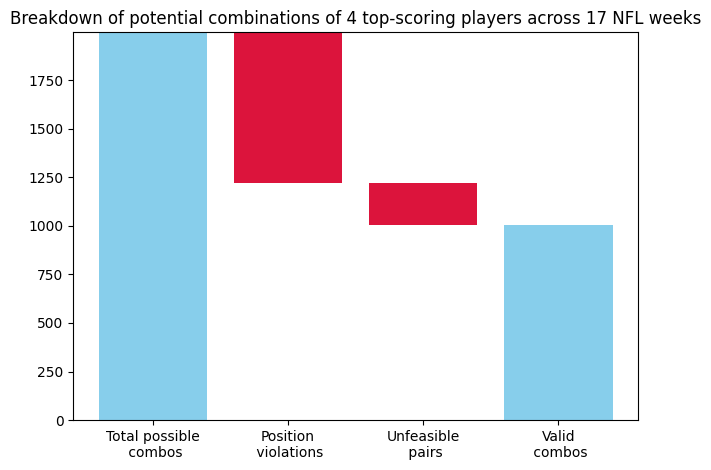

In [58]:
# Update the data
top_num = 4
final = dict_combos[top_num] - dict_pos_violations[top_num] - dict_unfeasible[top_num]
index = ['Total possible\n combos', 'Position\n violations', 'Unfeasible\n pairs', 'Valid\n combos']
data = {'amount': [dict_combos[top_num], -dict_pos_violations[top_num], -dict_unfeasible[top_num], final]}

# Create DataFrame
df_chart = pd.DataFrame(data, index=index)

# Calculate the cumulative sum
df_chart['cumulative'] = df_chart['amount'].cumsum()

# Determine the colors of the bars
df_chart['colors'] = ['skyblue' if x > 0 else 'crimson' for x in df_chart['amount']]

# Create the waterfall chart
fig, ax = plt.subplots()

# Create the initial bar
ax.bar(df_chart.index[0], df_chart['amount'].iloc[0], color=df_chart['colors'].iloc[0])

# Create the intermediate bars
ax.bar(df_chart.index[1:-1], df_chart['amount'].iloc[1:-1], bottom=df_chart['cumulative'].iloc[:-2], color=df_chart['colors'].iloc[1:-1])

# Create the final bar
ax.bar(df_chart.index[-1], df_chart['amount'].iloc[-1],  color=df_chart['colors'].iloc[-1]) #bottom=df_chart['cumulative'].iloc[-2],

# Format the y-axis to be percentage
#formatter = FuncFormatter(lambda y, pos: "%d%%" % (100 * y))
#ax.yaxis.set_major_formatter(formatter)

# Remove the y-axis label
ax.set_ylabel('')

# Set the title of the chart
ax.set_title('Breakdown of potential combinations of 4 top-scoring players across 17 NFL weeks')

# Display the plot
plt.tight_layout()
plt.show()


The code above calculates the possible combinations of 2-6 top-scorers in each week, then eliminates combinations that would violate the Underdog position limits (e.g., more than 1 QB or TE), then eliminates combinations with two players who couldn't feasibly be drafted together. This chart shows the results of this process for combinations of 4 top scorers - there were roughly 2,000 potential combos of 4 top scorers over the entire 17 weeks, ~750 violated position limits, and ~250 were deemed unfeasible to be drafted together.

This draft feasibility adjustment is the trickiest part so I will take some space to explain it.  I wanted to eliminate combos that couldn't be drafted together, not those who were never drafted together, because I don't want my analysis to be influenced by contestant's draft choices. Here's a summary of my process in pseudocode:

In [ ]:
# Loop through each pair of players in a combo
    # Pull the list of picks at which player 1 was drafted
    # Loop through each of these picks
        # Calculate how frequently player 1 was taken at this pick - call this X%
        # Pull the list of all other picks for this draft slot (1-12) 
        # Loop through each of these picks
            # Calculate how frequently player 2 was available at each pick - call this Y%
            # Multiply X% by Y% and add it to a running total for this pair
    # Repeat process above from player 2's perspective
    #- If running total < 1 for this pair, label this combo unfeasible

If a pair's running total is less than 1, then on average there was less than 1 opportunity per draft for the two players to be selected together. Setting this minimum to 1 probably labels too many combinations feasible, but my primary goal was to eliminate the most unfeasible combos.

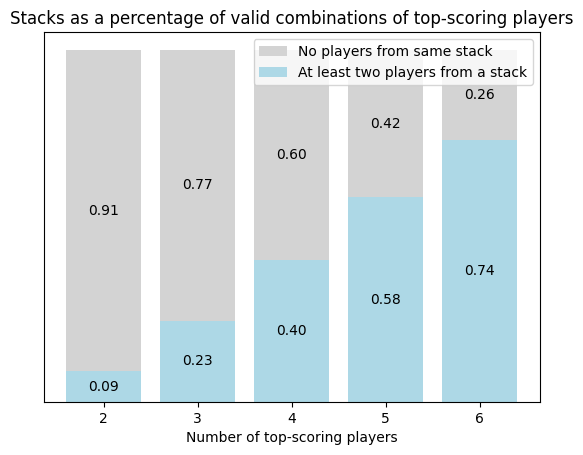

In [43]:
# Create new column showing number of unstacked combos
df_combo['unstacked'] = df_combo['combo_ct'] - df_combo['stack_ct']

# Check the unique values in the 'top_skill_ct' column
unique_top_skills = df_combo['top_skill_ct'].unique()

# Group the data by 'top_skill_ct'
grouped_data = df_combo.groupby('top_skill_ct').sum()[['stack_ct', 'unstacked', 'combo_ct']]

# Calculate the proportions
grouped_data['stack_ct'] /= grouped_data['combo_ct']
grouped_data['unstacked'] /= grouped_data['combo_ct']

# Modify the plot to include only the required x-axis labels

fig, ax = plt.subplots()

# Plot with lighter shades of blue and gray
bars1 = ax.bar(grouped_data.index, grouped_data['stack_ct'], color='lightblue', label='At least two players from a stack')
bars2 = ax.bar(grouped_data.index, grouped_data['unstacked'], bottom=grouped_data['stack_ct'], color='lightgray', label='No players from same stack')

# Remove the y-axis and its labels
ax.set_xlabel('Number of top-scoring players')
ax.set_ylabel('')
ax.set_title('Stacks as a percentage of valid combinations of top-scoring players')

# Reverse the order of the items in the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# Set x-ticks to be only the unique values of 'top_skill_ct'
ax.set_xticks(unique_top_skills)

# Remove y-ticks
ax.set_yticks([])

# Add data labels
for rects in (bars1, bars2):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height / 2. + rect.get_y(),
                f'{height:.2f}', ha='center', va='center', color='black')

plt.show()

This is the most important chart in this notebook. It shows that the larger the combination of top scorers, the greater share of valid combinations that include 2 or more team or game-stacked players from the same stack.

As an example, a completely unstacked lineup would only be able to access 60% of all feasible combinations of 4 top scorers. To access the other 40%, you need some kind of stack.

Many factors could drive this phenomenon, but it's partly simple probability. Assume you have 10 top scorers and 2 are from the same team. If you start with 1 of the teammates and randomly select 2 other top scorers, you have two chances to select the other teammate. If you select 3 other top scorers, you have 3 chances to select the other roommate, which means a higher likelihood of doing so.

This phenomenon depends on multiple players from the same stack finding their way into the pool of top scorers. That's where correlation of on-field performances comes into play - if player outcomes were less correlated last year, the absolute levels of the stack shares in this chart would be lower, but larger combos would still have a higher share of stacks than smaller combos.

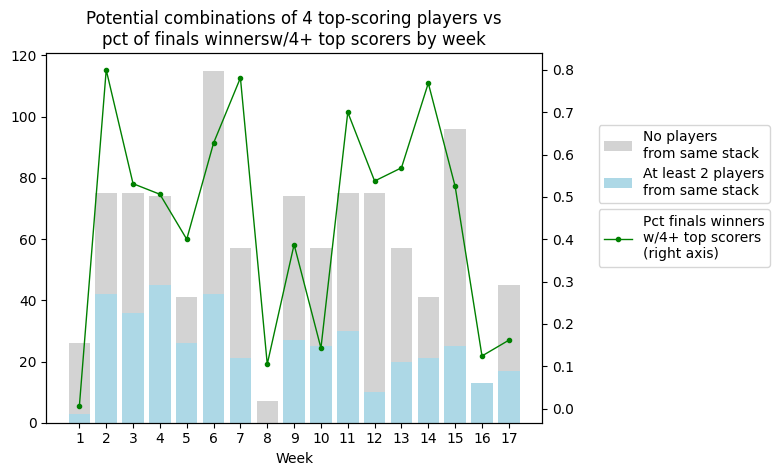

In [80]:


# Create the new column 'top_stack'
df_combo['top_stack'] = df_combo['combo_ct'] - df_combo['stack_ct']

# Filter data where 'top_skill_ct' is 4
data = df_combo[df_combo['top_skill_ct'] == 4]


# Group the data by 'week'
grouped_data = data.groupby('week').sum()

# Group finalist data by 'top_skill_ct'
gb_optimal_stack_entry_output['four'] = np.where(gb_optimal_stack_entry_output['top_skill_or_qb']>=4, 1,0)
grouped_finalists = gb_optimal_stack_entry_output[(gb_optimal_stack_entry_output['finals']>0)].groupby(
    by=['week']).agg(four = ('four', 'mean'))

# Create a new figure
fig, ax = plt.subplots()

# Stacked column chart
bars1 = ax.bar(grouped_data.index, grouped_data['stack_ct'], color='lightblue', label='At least 2 players\nfrom same stack')
bars2 = ax.bar(grouped_data.index, grouped_data['top_stack'], bottom=grouped_data['stack_ct'], color='lightgray', label='No players\nfrom same stack')

# Set the labels and title
ax.set_xlabel('Week')
ax.set_ylabel('')
ax.set_title('Potential combinations of 4 top-scoring players vs\npct of finals winnersw/4+ top scorers by week')

# Reverse the order of the items in the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.1, 0.7))

# Set x-ticks to be every single week
ax.set_xticks(grouped_data.index)

# Create a twin Axes sharing the x-axis
ax2 = ax.twinx()

# Line plot on the secondary y-axis
ax2.plot(grouped_finalists.index, grouped_finalists['four'], color='green', marker='o', label='Pct finals winners\nw/4+ top scorers\n(right axis)', linewidth=1, markersize=3)

# Add a legend for the line plot
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

plt.show()


The number of valid combinations of top scorers is highly volatile. This chart shows that the number of valid combos of 4 top scorers varied from <10 to over >100 in 2022. In general, the percentage of finals winners that had 4+ top scorers varied with this total, but the relationship isn't perfect.

This means that stacking's ability to increase odds of winning is largely determined by the variance of on-field outcomes in a given week. There's a much better chance of a stacked lineup winning if week 17 of BBM IV looks like week 2 of BBM III, than if it looks like week 8.

Speaking of week 17 and variance, let's circle back to our old friend Pat. You might ask, if most finals winners in our simulated tournaments had 3 or 4 top scorers, how did Pat win with just 2 that didn't come from the same stack? Well the chart above shows that week 17 wasn't the best in terms of number of valid top scorer combos or the percent of winners with 4+ top scorers.

In [89]:
# WIP combos among week 17 finalists
df_finalists = df[df['latest_rd']==4].groupby(by=['tournament_entry_id'], as_index=False).agg(
    score = ('score_17', 'sum')
)

gb_finalists = gb_optimal_stack_entry_output[(gb_optimal_stack_entry_output['week']==17)&
    (gb_optimal_stack_entry_output['tournament_entry_id'].isin(df_finalists['tournament_entry_id']))].groupby(
        by = ['tournament_entry_id'], as_index=False
    ).agg(
        top_skill_or_qb = ('top_skill_or_qb', 'sum'),
        top_skill_same_stack = ('top_skill_same_stack', 'sum'),
        top_skill_same_partial_stack = ('top_skill_same_partial_stack', 'sum'),
        
    )
dict_finalists_top = dict(zip(gb_finalists['tournament_entry_id'], gb_finalists['top_skill_or_qb']))
dict_finalists_stack = dict(zip(gb_finalists['tournament_entry_id'], gb_finalists['top_skill_same_stack']))
dict_finalists_stack_partial = dict(zip(gb_finalists['tournament_entry_id'], gb_finalists['top_skill_same_partial_stack']))
df_finalists['top_skill_or_qb'] = df_finalists['tournament_entry_id'].map(dict_finalists_top)
df_finalists['top_skill_same_stack'] = df_finalists['tournament_entry_id'].map(dict_finalists_stack)
df_finalists['top_skill_same_partial_stack'] = df_finalists['tournament_entry_id'].map(dict_finalists_stack_partial)
df_finalists = df_finalists[['tournament_entry_id', 'score', 'top_skill_or_qb', 'top_skill_same_stack', 'top_skill_same_partial_stack']].sort_values(by=['top_skill_or_qb', 'score'], ascending=False)
df_finalists = df_finalists.rename(columns={'top_skill_or_qb':'Top scorers', 'top_skill_same_stack': 'From same stack', 'top_skill_same_partial_stack':'From same partial stack'})
df_finalists.head()

,tournament_entry_id,score,Top scorers,From same stack,From same partial stack
377,c5325171-447b-40b1-a119-103917f06203,161.78,2,0,0
463,fa25d3f7-d880-421e-9ae8-8abc34abe300,156.62,2,0,0
32,11338fa5-f9b3-473a-ae28-5c6e3cd36965,154.42,2,0,0
410,d76f87cb-103c-40c1-b81f-bb62db0c7c0e,152.18,2,0,0
59,1c6edbfe-8c34-42b5-9d38-4362aa6cacf2,150.20,2,0,0


This table ranks teams in the actual week 17 finals of BBM III, first by how many top scorers they had, then by their score. That's Mr. Kerrane's lineup at the top. No lineup in the actual finals had more than 2 top scorers. Moreover, most of entries with 2 top scorers did not get them from the same stack. 

Does that invalidate our analysis above? No. Week 17 2022 wasn't a great week for stacked top scorers, but many other weeks were. Stacking gives you a better chance of capturing outlier performances in those better weeks and still lets you compete in the more meager weeks. You can't pick the week 17 2023 game environment, but you can prepare for it.

# Summary and conclusion

Here's what I'm trying to say with this analysis:
- Every week a certain number of players will have outlier performances
- You're gonna need as many of these players in your lineup as possible to win the finals
- Because on-field correlation results in multiple players in the same game achieving outlier scores, stacking gives you access to more combinations of top scorers
- The importance and potential impact of stacking on your ability to capture outlier performances varies greatly, but it's a strategy that increases your odds of winning in most environments

Here's some additional implications and considerations I did not have time to flesh out:
- Most top scorers are also drafted early - their average ADP is roughly 50, which suggests premium stacks are especially valuable
- The best offenses accounted for an outsized share of top scorers,so stacking below average teams probably isn't going to let you leverage the benefits outlined here
- The story here is the same if we simulate tournaments with all 415,200 BBM III entries
- This analysis did not explore other potential sources of stack value in depth, so my claim is not that this is the only source of value stacks provides...it's just a big one